In [1]:
import json, os,sys
import numpy as np
sys.path.append('C:\\Users\\dell\\Desktop\\phasemapy')
from copy import deepcopy

In [2]:
import os
os.getcwd()

'C:\\Users\\dell\\Desktop\\phasemapy\\scripts_Cu-Fe-V-O'

In [3]:
sys.path

['C:\\Users\\dell\\Desktop\\phasemapy\\scripts_Cu-Fe-V-O',
 'C:\\Users\\dell\\anaconda3\\envs\\myPymatgen\\python37.zip',
 'C:\\Users\\dell\\anaconda3\\envs\\myPymatgen\\DLLs',
 'C:\\Users\\dell\\anaconda3\\envs\\myPymatgen\\lib',
 'C:\\Users\\dell\\anaconda3\\envs\\myPymatgen',
 '',
 'C:\\Users\\dell\\anaconda3\\envs\\myPymatgen\\lib\\site-packages',
 'C:\\Users\\dell\\anaconda3\\envs\\myPymatgen\\lib\\site-packages\\lmptools-0.1.0-py3.7.egg',
 'C:\\Users\\dell\\anaconda3\\envs\\myPymatgen\\lib\\site-packages\\emmet_core-0.34.5-py3.7.egg',
 'C:\\Users\\dell\\anaconda3\\envs\\myPymatgen\\lib\\site-packages\\win32',
 'C:\\Users\\dell\\anaconda3\\envs\\myPymatgen\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\dell\\anaconda3\\envs\\myPymatgen\\lib\\site-packages\\Pythonwin',
 'C:\\Users\\dell\\anaconda3\\envs\\myPymatgen\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\dell\\.ipython',
 'C:\\Users\\dell\\Desktop\\phasemapy']

In [4]:
!dir

 驱动器 C 中的卷没有标签。
 卷的序列号是 346F-7C10

 C:\Users\dell\Desktop\phasemapy\scripts_Cu-Fe-V-O 的目录

2022/09/15  12:15    <DIR>          .
2022/09/09  20:15    <DIR>          ..
2022/04/19  04:53             6,148 .DS_Store
2022/09/14  16:05    <DIR>          .ipynb_checkpoints
2022/09/14  20:42           114,457 amps_9sample_sno2.npy
2022/09/05  16:23    <DIR>          data
2022/05/18  06:51               186 environment.yaml
2022/09/05  16:23    <DIR>          initial_pruning
2022/09/14  20:44           177,397 Instance_data_9samples_near_volcano.ipynb
2022/05/14  05:11            13,831 PDF_Card_01-080-6417_SnO2.xy
2022/04/21  15:08            67,321 refinement.ipynb
2022/05/14  05:11            71,653 samples_near_volcano.xy
2022/09/15  12:17    <DIR>          solution
2022/09/05  15:48    <DIR>          solution_figures
2022/09/15  12:15           611,627 solver_Cu-fe-V-Copy1.ipynb
2022/09/14  13:46         1,758,113 solver_Cu-fe-V.ipynb
2022/06/07  17:17             5,948 step0_preprcess_i

In [5]:
!dir data

 驱动器 C 中的卷没有标签。
 卷的序列号是 346F-7C10

 C:\Users\dell\Desktop\phasemapy\scripts_Cu-Fe-V-O\data 的目录

2022/09/05  16:23    <DIR>          .
2022/09/15  12:15    <DIR>          ..
2022/04/19  04:53             6,148 .DS_Store
2022/02/21  15:55            14,868 3577_CuFeV_compositions.csv
2022/02/21  15:55         3,686,692 Fe-Cu-V-609-Q666-inst_with28.txt
2022/05/06  20:41         8,806,997 Fe-Cu-V-O-raw_background.txt
2022/09/05  16:23    <DIR>          icdd
2022/06/07  17:17         1,264,567 icdd_entries.json
2022/04/21  16:38             3,717 kainotropite.cif
2022/02/21  15:55            10,638 pdfnames_list.txt
2022/02/21  15:55            11,649 pdfnames_list_normalizedComps.csv
2022/04/26  15:42        16,292,974 raw_data_Fe_Cu_V.txt
2022/05/18  08:49             1,110 SnO2_mp-856_symmetrized.cif
2022/02/21  15:55           364,014 VFeCuO_20200615174936.sticks
              11 个文件     30,463,374 字节
               3 个目录 347,006,058,496 可用字节


In [6]:
from pymatgen.core import Element
from monty.json import MontyDecoder, MontyEncoder
from pymatgen.analysis.diffraction.xrd import XRDCalculator
import numpy as np
from phasemapy.dataio import InstanceData
from phasemapy.parser import ICDDEntry
from phasemapy.solver import Phase, Sample
import matplotlib.pyplot as plt
chemsys = ['Cu', 'Fe', 'V']
oxide_system = True
photon_e = 13e3
max_q_shift = 0.05
resample_density = 1000
initial_alphagamma = 0.1
SUM_NORM = 6000
loss_weight = {'xrd_loss': 6.0, 'comp_loss': 2.0, 'entropy_loss': 0.2}
instance_data = InstanceData.from_file('./data/Fe-Cu-V-O-raw_background.txt', chemsys, photon_e)

# instance_data = InstanceData.from_file('./data/Fe-Cu-V-609-Q666-inst_with28.txt', chemsys, photon_e)
#./data/Fe-Cu-V-609-Q666-inst_with28.txt
#instance_data = instance_data.resample_xrd(resample_density)



Bad key text.latex.preview in file C:\Users\dell\anaconda3\envs\myPymatgen\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\dell\anaconda3\envs\myPymatgen\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\dell\anaconda3\envs\myPymatgen\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is save

In [7]:
 np.min(instance_data.sample_xrd,axis=0)

array([149.116, 150.545, 152.976, ..., 431.787, 432.185, 432.588])

In [8]:
instance_data.sample_num

609

In [9]:
instance_data.wavelength

0.9537246033323097

In [10]:
instance_data.sample_xrd.shape


(609, 1199)

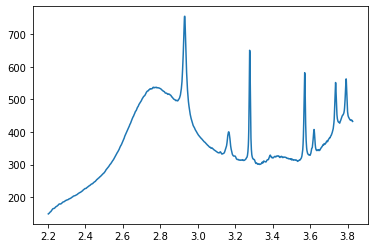

In [11]:
background = np.min(instance_data.sample_xrd,axis=0)
plt.plot(instance_data.log_q,background)

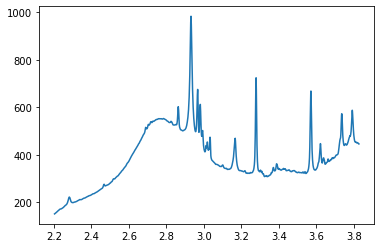

In [12]:
plt.plot(instance_data.log_q,instance_data.sample_xrd[12])
# plt.plot(instance_data.log_q,instance_data.sample_xrd[12]-background)

In [13]:
instance_data.sample_xrd-=background 
instance_data.renormalize(norm=SUM_NORM)

In [14]:
np.argmin(instance_data.sample_xrd)

4805

In [15]:
np.min(instance_data.sample_xrd)

0.0

In [16]:
np.min(instance_data.sample_xrd[1])

0.41846320044304725

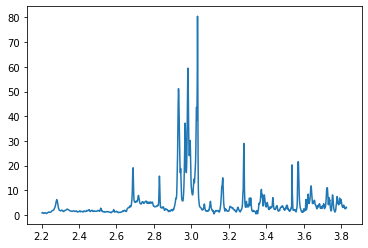

In [17]:
plt.plot(instance_data.log_q,instance_data.sample_xrd[1])

In [18]:
with open('./data/icdd_entries.json') as f:
    entries = json.load(f, cls=MontyDecoder)
print(len(entries))

77


In [19]:
entries[1].data

{'xrd': [array([22.831466, 24.821012, 24.90142 , 27.027991, 27.183404, 32.0457  ,
         33.677247, 35.324072, 36.690133, 38.732241, 39.697396, 41.73505 ,
         44.297274, 44.581656, 44.711864, 45.531408, 45.662932, 46.137755,
         47.790571, 48.154115, 48.472215, 49.642024, 49.80284 , 52.271903,
         52.550373, 52.580826, 53.743787, 54.055982, 54.281932, 54.366809,
         55.947352, 56.035654, 56.625697, 56.68869 , 57.553562]),
  array([ 6.459741, 24.245193, 69.835914, 83.315302, 18.876823,  1.881743,
         25.811902,  1.255663,  9.134277,  0.56093 , 14.14403 , 18.786812,
         16.535047, 14.66603 ,  0.436608,  9.693677, 14.735003,  0.252467,
          0.321928,  7.9335  ,  0.201731,  6.034838,  6.295061,  0.145265,
          2.25796 ,  0.212224,  5.464297,  4.8113  ,  0.186794,  4.383035,
          1.870918,  0.110813,  0.159902,  0.01756 ,  7.262049])]}

In [20]:
entries[1].pressure_temperature


'Ambient'

In [21]:
chemsys[0]

'Cu'

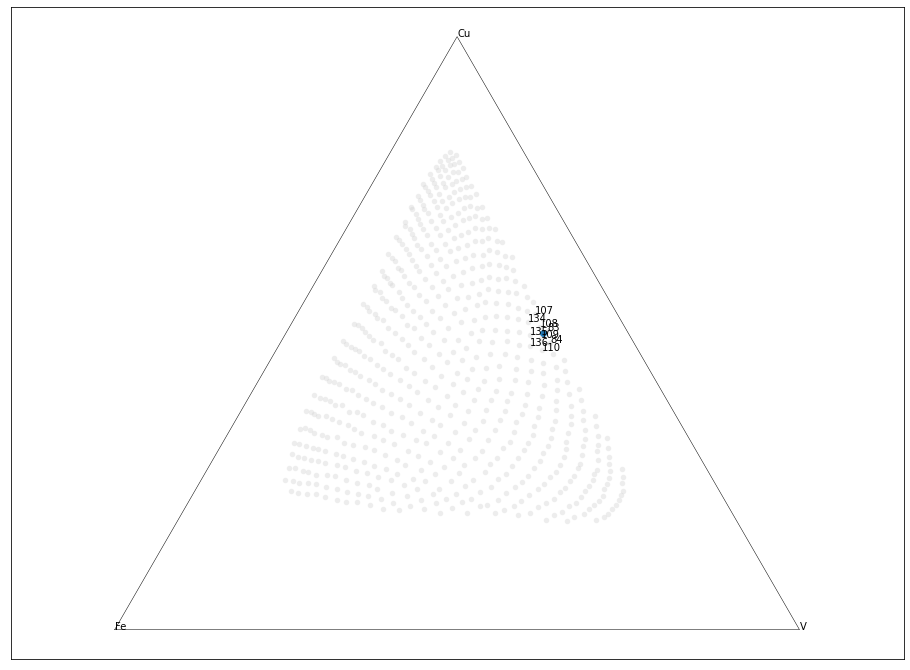

In [22]:
def get_plot(instance_data, sequence):
    chemsys = instance_data.chemsys
    i, j = chemsys.index(sequence[-1]), chemsys.index(sequence[0])
    unitvec = np.array([[1, 0], [0.5, np.sqrt(3) / 2]])
    x, y = np.dot(instance_data.sample_comp[:, (i, j)], unitvec).T
    fig = plt.figure(figsize=(8*2,6*2))
    ax = plt.subplot()
    comp = entries[-1].composition
    vacalno_comp = np.array([comp[Element(chemsys[2])],comp[Element(chemsys[0])]])/(comp.num_atoms-comp[Element('O')])
    vacalno_loc = np.dot(vacalno_comp, unitvec).T

    
    ax.scatter(x, y, s=30, c='lightgrey', alpha=0.4, lw=0)
#         label = ge.name + '\n' + ge.entry_id
#         phase_amt = act.phase_amount_matrix[:, i]
#         ax.scatter(x, y, s=30 * phase_amt, c=f'C{i}', lw=0, label=label)
    ax.plot([0, 1, 0.5, 0], [0, 0, np.sqrt(3) / 2, 0], 'k', lw=0.5)
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    
    
    mid_loc = np.dot(np.array([1/3,1/3]),unitvec).T
    
    
#     for k in [0,193,485,65,67,327,542,224]:
#         ax.scatter()
    
    nn = []
    for k in range(instance_data.sample_num):
        #if (x[k]-mid_loc[0])**2+(y[k]-mid_loc[1])**2<0.002:
        if (x[k]-vacalno_loc[0])**2+(y[k]-vacalno_loc[1])**2<0.001:
            ax.text(x[k],y[k],str(k))
            nn.append(k)
#         ax.text(0.65, 0.7, label)
#         comp_v = np.array([ge.composition[Element(el)] for el in sequence])
#         comp_v /= np.sum(comp_v)

#         comp_v = np.array([comp_v[-1], comp_v[0]])
#         x0, y0 = np.dot(comp_v, unitvec).T
    ax.text(1, 0, sequence[-1])
    ax.text(0, 0, sequence[1])
    ax.text(0.5, np.sqrt(3) / 2, sequence[0])
    
        
    plt.scatter(*np.dot(vacalno_comp, unitvec).T)# Cu4FeV3

    return nn


nn = get_plot(instance_data,chemsys)








In [23]:
nn

[83, 84, 107, 108, 109, 110, 134, 135, 136]

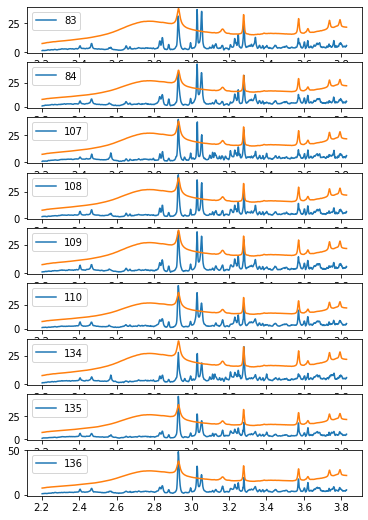

In [24]:
#nn = [62, 63, 83, 84, 85, 86, 106, 107, 108, 109, 110, 111, 112, 132, 133, 134, 135, 136, 137, 138, 159, 160, 161, 162, 163, 164, 165, 188, 189, 190, 191, 192, 218]

fig,axes = plt.subplots(ncols=1,nrows=len(nn),figsize=(6,len(nn)))
for k,ax in zip(nn,axes):
    ax.plot(instance_data.log_q, instance_data.sample_xrd[k],'-',label=str(k))
    ax.plot(instance_data.log_q,background*0.05)
    ax.legend()
    
    

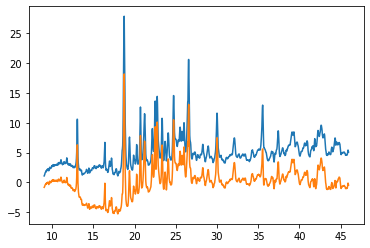

In [25]:
k=159
#plt.figure(figsize=(8,6))
plt.plot(np.exp(instance_data.log_q), instance_data.sample_xrd[k],'-')
plt.plot(np.exp(instance_data.log_q),instance_data.sample_xrd[k]-background/78)

In [26]:
solution = [Phase.from_entry_and_instance_data(entries[-1], 1, instance_data),]

sample = Sample(k, instance_data.log_q, instance_data.sample_xrd[k], instance_data.chemsys,
                        instance_data.sample_comp[k], oxide_system, instance_data.wavelength, max_q_shift, solution)

<module 'matplotlib.pyplot' from 'C:\\Users\\dell\\anaconda3\\envs\\myPymatgen\\lib\\site-packages\\matplotlib\\pyplot.py'>

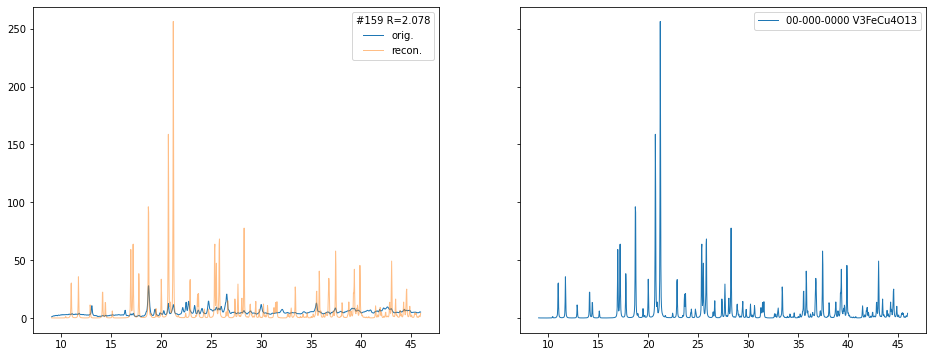

In [27]:
sample.plot(perphase=True)

In [28]:
# def remove_negative():
#     for k in range(instance_data.sample_num):
#         #print (np.max(instance_data.sample_xrd[k]))
#         threshold = 0.002*np.max(instance_data.sample_xrd[k])
#         intensity = instance_data.sample_xrd[k]
#         while np.min(intensity)<threshold:
#             center_log_q = instance_data.log_q[np.argmin(instance_data.sample_xrd[k])]
#             sigma=0.1
#             gaussian = (threshold-np.min(intensity))* np.exp(-np.power((instance_data.log_q - center_log_q)/sigma, 2.)/2.)
#             #plt.plot(instance_data.log_q,gaussian)
#             intensity += gaussian
        
# remove_negative()                                      
    #plt.plot(np.exp(instance_data.log_q), intensity)


In [29]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d

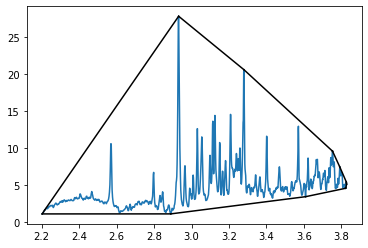

In [30]:

plt.plot(instance_data.log_q, instance_data.sample_xrd[k],'-')
points = np.array([instance_data.log_q, instance_data.sample_xrd[k]]).T
hull = ConvexHull(points)
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')


In [31]:
chemsys

['Cu', 'Fe', 'V']

In [32]:
#np.dot(np.array(, unitvec).T

In [33]:
# plt.figure(figsize=(8*2,6*2))
# instance_data1 = InstanceData.from_file('./data/raw_data_Fe_Cu_V.txt', chemsys, photon_e)
# k=290

# plt.plot(np.exp(instance_data1.log_q), instance_data1.sample_xrd[k]/np.max(instance_data1.sample_xrd[k]),'o-')


# instance_data2 = InstanceData.from_file('./data/Fe-Cu-V-609-Q666-inst_with28.txt', chemsys, photon_e)

# plt.plot(np.exp(instance_data2.log_q), instance_data2.sample_xrd[k],'o-')



In [34]:
entries[-1].entry_id

'00-000-0000'

In [35]:
!ls ./solution

'ls' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


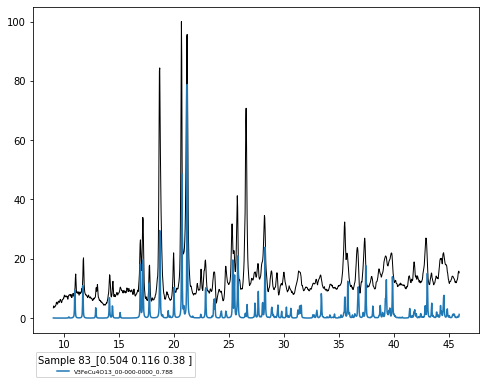

x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.8007, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
0 4.804178 tensor(0.8007) tensor(0.0001) tensor(1.1921e-07)
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.7603, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.7518, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad

x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.7278, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.7277, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.7275, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.7274, grad_fn=<DivBackward0>) ten

x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.7188, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.7187, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.7185, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.7183, grad_fn=<DivBackward0>) tensor(

x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.7131, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.7129, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.7128, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.7127, grad_fn=<DivBackward0>) tensor(1.19

loss tensor(0.7049, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.7046, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.7043, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.7041, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tenso

x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.6991, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.6990, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.6989, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.6988, grad_fn=<DivBackwar

entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.6963, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.6962, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.6962, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.6961, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tens

entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.6949, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.6949, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.6949, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.6949, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) 

loss tensor(0.6949, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.6949, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.6949, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.6949, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy t

x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.6949, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.6949, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.6949, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.6949, grad_fn=<DivBackward0>) ten

x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.6949, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.6949, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.6949, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.6949, grad_fn=<DivBackward0>) tensor(

loss tensor(0.6948, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.6948, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.6948, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.6948, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1

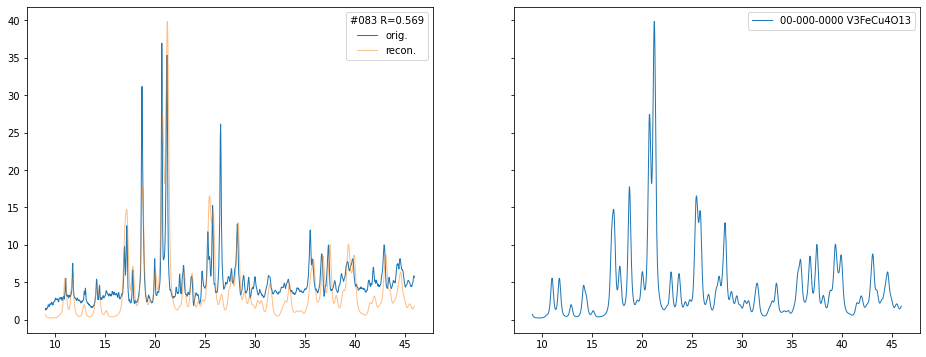

In [36]:
        i=83
        solution = []
        for e in entries:
            phase = Phase.from_entry_and_instance_data(e, 1 / len(entries), instance_data)
            solution.append(phase)
            
        solution = [Phase.from_entry_and_instance_data(entries[-1], 1, instance_data,width=0.1)]    

        sample = Sample(i, instance_data.log_q, instance_data.sample_xrd[i], instance_data.chemsys,
                        instance_data.sample_comp[i], oxide_system, instance_data.wavelength, max_q_shift, solution)
        sample.prune_candidates_based_on_composition(cutoff=0.05)
        sample.prune_candidate_based_on_xrd(plot=True, cutoff=0.08)
        new_sample = deepcopy(sample)
        
        new_sample = new_sample.optimize(num_epoch=500, print_prog=True, loss_weight=loss_weight)
        #new_sample.update_solution(0.03, 0.2999, new_sample.max_q_shift)
        new_sample.print_solution()
        new_sample.plot(perphase=True)
        
        new_sample.refine_all_fractions()
        new_sample.refine_one_by_one()
        

In [37]:
!open initial_pruning/fig_83.pdf

'open' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


In [38]:
for i in [83]: #range(instance_data.sample_num):
    solution_file = f'solution/samples{i}.json'
    if os.path.exists(solution_file):
        continue
        with open(solution_file) as f:
            sample = json.load(f, cls=MontyDecoder)
        continue
    else:
        print(f'Solving sample {i} ......')
        solution = [Phase.from_entry_and_instance_data(entries[-1], 1, instance_data,width=0.1)]
        
#         solution = []
#         for e in entries:
#             phase = Phase.from_entry_and_instance_data(e, 1 / len(entries), instance_data)
#             solution.append(phase)

        sample = Sample(i, instance_data.log_q, instance_data.sample_xrd[i], instance_data.chemsys,
                        instance_data.sample_comp[i], oxide_system, instance_data.wavelength, max_q_shift, solution)
#         sample.prune_candidates_based_on_composition(cutoff=0.05)
#         sample.prune_candidate_based_on_xrd(plot=True, cutoff=0.1, saveplot=f'initial_pruning/fig_{i}.pdf')
        #sample.print_solution()
        
        
        if len(sample.solution)>0 and len(sample.solution)<30:
            print (sample.sample_id,len(sample.solution))
            solution_file = f'solution/samples{i}.json'
            with open(solution_file, 'w') as f:
                json.dump(sample, f, cls=MontyEncoder)
    
        
        
# #         print(sample.sample_id, sample.loss(loss_weight))
        
        new_sample = deepcopy(sample)
        
#         #new_sample.refine_all_fractions()
#         #new_sample.refine_one_by_one()
        
        new_sample = new_sample.optimize(num_epoch=500, print_prog=True, loss_weight=loss_weight)
        new_sample.update_solution(0.03, 0.2999, new_sample.max_q_shift)
        new_sample.refine_all_fractions()
        new_sample.refine_one_by_one()
        new_sample.update_solution(0.03, 0.2999, new_sample.max_q_shift)
        new_sample.print_solution()
        #new_sample.refine_all_fractions()
#         new_sample = new_sample.optimize(num_epoch=1000, print_prog=True, loss_weight=loss_weight)
#         new_sample.update_solution(0.01, 0.2999, new_sample.max_q_shift)
#         new_sample.refine_one_by_one()
#         new_sample.refine_all_fractions()
#         new_sample.update_solution(0.01, 0.2999, new_sample.max_q_shift)
#        print(new_sample.loss(loss_weight))
#         if new_sample.loss(loss_weight) <= sample.loss(loss_weight):
#             #sample.print_solution()
#             new_sample.print_solution()
#             #samples[sample.sample_id] = new_sample
#             solution_file = f'solution/samples{i}.json'
#             with open(solution_file, 'w') as f:
#                 json.dump(new_sample, f, cls=MontyEncoder)
#             print(sample.sample_id, sample.loss(loss_weight))


<module 'matplotlib.pyplot' from 'C:\\Users\\dell\\anaconda3\\envs\\myPymatgen\\lib\\site-packages\\matplotlib\\pyplot.py'>

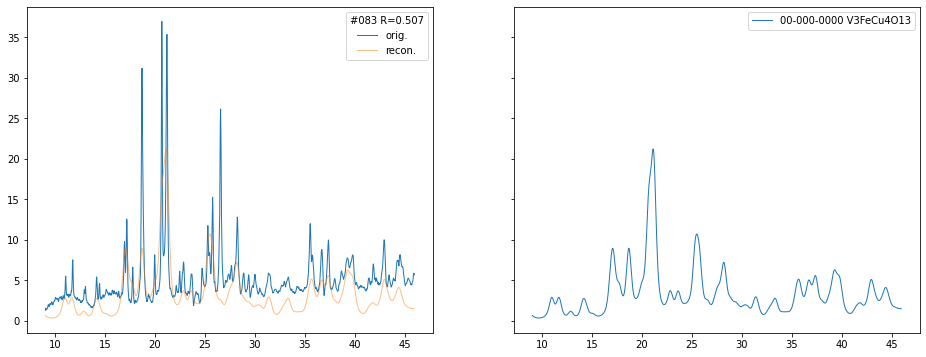

In [39]:
new_sample.plot(perphase=True)

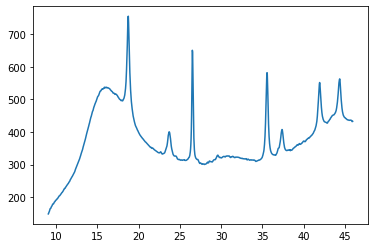

In [40]:
plt.plot(np.exp(instance_data.log_q),background)

In [42]:
instantce_data

NameError: name 'instantce_data' is not defined

Solving sample 0 ......
Sample: # 0
  Name     Entry_id  fraction     shift  width
0  VO2  04-007-1466       1.0  0.049136    0.3
Current R^2 = 0.6191527428492107
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.2746, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.2453, grad_fn=<MseLossBackward0>)
0 8.138111 tensor(1.2746) tensor(0.2453) tensor(1.1921e-07)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1668, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.2453, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1330, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.

entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.9476, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.2453, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.9472, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.2453, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.9469, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.2453, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.9466, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0

x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.9381, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.2453, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.9380, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.2453, grad_fn=<MseLossBackward0>)
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.9378, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.2453, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.9377, grad_fn=<DivBackward0>) ten

loss tensor(0.9332, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.2453, grad_fn=<MseLossBackward0>)
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.9331, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.2453, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.9330, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.2453, grad_fn=<MseLossBackward0>)
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.9329, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.2453, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tenso

x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.9321, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.2453, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.9320, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.2453, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.9320, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.2453, grad_fn=<MseLossBackward0>)
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.9320, grad_fn=<DivBackward0>) ten

x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.9317, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.2453, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.9317, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.2453, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.9317, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.2453, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.9317, grad_fn=<DivBackward0>) tensor(1.19

x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.9316, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.2453, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.9316, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.2453, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.9316, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.2453, grad_fn=<MseLossBackward0>)
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.9316, grad_fn=<DivBackward0>) ten

x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.9316, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.2453, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.9316, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.2453, grad_fn=<MseLossBackward0>)
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.9316, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.2453, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.9316, grad_fn=<DivBackward0>) tensor(

x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.9316, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.2453, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.9316, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.2453, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.9316, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.2453, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.9316, grad_fn=<DivBackward0>) tensor(1.19

x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.9316, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.2453, grad_fn=<MseLossBackward0>)
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.9316, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.2453, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.9316, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.2453, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.9316, grad_fn=<DivBackward0>) tensor(

loss tensor(0.9316, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.2453, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.9316, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.2453, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.9316, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.2453, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(0.9316, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.2453, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.192

x tensor([[0.5902, 0.4098]], grad_fn=<SumBackward1>)
entropy tensor([0.6768], grad_fn=<NegBackward0>) tensor(0.6768, grad_fn=<MeanBackward0>)
loss tensor(0.7776, grad_fn=<DivBackward0>) tensor(0.6768, grad_fn=<MeanBackward0>) tensor(0.1280, grad_fn=<MseLossBackward0>)
x tensor([[0.5916, 0.4084]], grad_fn=<SumBackward1>)
entropy tensor([0.6763], grad_fn=<NegBackward0>) tensor(0.6763, grad_fn=<MeanBackward0>)
loss tensor(0.7769, grad_fn=<DivBackward0>) tensor(0.6763, grad_fn=<MeanBackward0>) tensor(0.1282, grad_fn=<MseLossBackward0>)
x tensor([[0.5929, 0.4071]], grad_fn=<SumBackward1>)
entropy tensor([0.6758], grad_fn=<NegBackward0>) tensor(0.6758, grad_fn=<MeanBackward0>)
loss tensor(0.7762, grad_fn=<DivBackward0>) tensor(0.6758, grad_fn=<MeanBackward0>) tensor(0.1284, grad_fn=<MseLossBackward0>)
x tensor([[0.5923, 0.4077]], grad_fn=<SumBackward1>)
entropy tensor([0.6760], grad_fn=<NegBackward0>) tensor(0.6760, grad_fn=<MeanBackward0>)
loss tensor(0.7759, grad_fn=<DivBackward0>) tensor(

x tensor([[0.6010, 0.3990]], grad_fn=<SumBackward1>)
entropy tensor([0.6726], grad_fn=<NegBackward0>) tensor(0.6726, grad_fn=<MeanBackward0>)
loss tensor(0.7713, grad_fn=<DivBackward0>) tensor(0.6726, grad_fn=<MeanBackward0>) tensor(0.1298, grad_fn=<MseLossBackward0>)
x tensor([[0.6010, 0.3990]], grad_fn=<SumBackward1>)
entropy tensor([0.6726], grad_fn=<NegBackward0>) tensor(0.6726, grad_fn=<MeanBackward0>)
loss tensor(0.7712, grad_fn=<DivBackward0>) tensor(0.6726, grad_fn=<MeanBackward0>) tensor(0.1298, grad_fn=<MseLossBackward0>)
x tensor([[0.6012, 0.3988]], grad_fn=<SumBackward1>)
entropy tensor([0.6725], grad_fn=<NegBackward0>) tensor(0.6725, grad_fn=<MeanBackward0>)
loss tensor(0.7711, grad_fn=<DivBackward0>) tensor(0.6725, grad_fn=<MeanBackward0>) tensor(0.1299, grad_fn=<MseLossBackward0>)
x tensor([[0.6013, 0.3987]], grad_fn=<SumBackward1>)
entropy tensor([0.6725], grad_fn=<NegBackward0>) tensor(0.6725, grad_fn=<MeanBackward0>)
loss tensor(0.7711, grad_fn=<DivBackward0>) tensor(

entropy tensor([0.6749], grad_fn=<NegBackward0>) tensor(0.6749, grad_fn=<MeanBackward0>)
loss tensor(0.7699, grad_fn=<DivBackward0>) tensor(0.6749, grad_fn=<MeanBackward0>) tensor(0.1288, grad_fn=<MseLossBackward0>)
x tensor([[0.5951, 0.4049]], grad_fn=<SumBackward1>)
entropy tensor([0.6749], grad_fn=<NegBackward0>) tensor(0.6749, grad_fn=<MeanBackward0>)
loss tensor(0.7699, grad_fn=<DivBackward0>) tensor(0.6749, grad_fn=<MeanBackward0>) tensor(0.1288, grad_fn=<MseLossBackward0>)
x tensor([[0.5948, 0.4052]], grad_fn=<SumBackward1>)
entropy tensor([0.6751], grad_fn=<NegBackward0>) tensor(0.6751, grad_fn=<MeanBackward0>)
loss tensor(0.7698, grad_fn=<DivBackward0>) tensor(0.6751, grad_fn=<MeanBackward0>) tensor(0.1288, grad_fn=<MseLossBackward0>)
x tensor([[0.5943, 0.4057]], grad_fn=<SumBackward1>)
entropy tensor([0.6753], grad_fn=<NegBackward0>) tensor(0.6753, grad_fn=<MeanBackward0>)
loss tensor(0.7698, grad_fn=<DivBackward0>) tensor(0.6753, grad_fn=<MeanBackward0>) tensor(0.1287, grad_

entropy tensor([0.6767], grad_fn=<NegBackward0>) tensor(0.6767, grad_fn=<MeanBackward0>)
loss tensor(0.7696, grad_fn=<DivBackward0>) tensor(0.6767, grad_fn=<MeanBackward0>) tensor(0.1280, grad_fn=<MseLossBackward0>)
x tensor([[0.5908, 0.4092]], grad_fn=<SumBackward1>)
entropy tensor([0.6766], grad_fn=<NegBackward0>) tensor(0.6766, grad_fn=<MeanBackward0>)
loss tensor(0.7696, grad_fn=<DivBackward0>) tensor(0.6766, grad_fn=<MeanBackward0>) tensor(0.1281, grad_fn=<MseLossBackward0>)
x tensor([[0.5910, 0.4090]], grad_fn=<SumBackward1>)
entropy tensor([0.6765], grad_fn=<NegBackward0>) tensor(0.6765, grad_fn=<MeanBackward0>)
loss tensor(0.7696, grad_fn=<DivBackward0>) tensor(0.6765, grad_fn=<MeanBackward0>) tensor(0.1281, grad_fn=<MseLossBackward0>)
x tensor([[0.5910, 0.4090]], grad_fn=<SumBackward1>)
entropy tensor([0.6765], grad_fn=<NegBackward0>) tensor(0.6765, grad_fn=<MeanBackward0>)
loss tensor(0.7696, grad_fn=<DivBackward0>) tensor(0.6765, grad_fn=<MeanBackward0>) tensor(0.1281, grad_

x tensor([[0.5899, 0.4101]], grad_fn=<SumBackward1>)
entropy tensor([0.6769], grad_fn=<NegBackward0>) tensor(0.6769, grad_fn=<MeanBackward0>)
loss tensor(0.7696, grad_fn=<DivBackward0>) tensor(0.6769, grad_fn=<MeanBackward0>) tensor(0.1279, grad_fn=<MseLossBackward0>)
x tensor([[0.5899, 0.4101]], grad_fn=<SumBackward1>)
entropy tensor([0.6769], grad_fn=<NegBackward0>) tensor(0.6769, grad_fn=<MeanBackward0>)
loss tensor(0.7696, grad_fn=<DivBackward0>) tensor(0.6769, grad_fn=<MeanBackward0>) tensor(0.1279, grad_fn=<MseLossBackward0>)
x tensor([[0.5899, 0.4101]], grad_fn=<SumBackward1>)
entropy tensor([0.6769], grad_fn=<NegBackward0>) tensor(0.6769, grad_fn=<MeanBackward0>)
loss tensor(0.7696, grad_fn=<DivBackward0>) tensor(0.6769, grad_fn=<MeanBackward0>) tensor(0.1279, grad_fn=<MseLossBackward0>)
x tensor([[0.5899, 0.4101]], grad_fn=<SumBackward1>)
entropy tensor([0.6769], grad_fn=<NegBackward0>) tensor(0.6769, grad_fn=<MeanBackward0>)
loss tensor(0.7696, grad_fn=<DivBackward0>) tensor(

x tensor([[0.5899, 0.4101]], grad_fn=<SumBackward1>)
entropy tensor([0.6769], grad_fn=<NegBackward0>) tensor(0.6769, grad_fn=<MeanBackward0>)
loss tensor(0.7695, grad_fn=<DivBackward0>) tensor(0.6769, grad_fn=<MeanBackward0>) tensor(0.1279, grad_fn=<MseLossBackward0>)
x tensor([[0.5898, 0.4102]], grad_fn=<SumBackward1>)
entropy tensor([0.6769], grad_fn=<NegBackward0>) tensor(0.6769, grad_fn=<MeanBackward0>)
loss tensor(0.7695, grad_fn=<DivBackward0>) tensor(0.6769, grad_fn=<MeanBackward0>) tensor(0.1279, grad_fn=<MseLossBackward0>)
x tensor([[0.5898, 0.4102]], grad_fn=<SumBackward1>)
entropy tensor([0.6769], grad_fn=<NegBackward0>) tensor(0.6769, grad_fn=<MeanBackward0>)
loss tensor(0.7695, grad_fn=<DivBackward0>) tensor(0.6769, grad_fn=<MeanBackward0>) tensor(0.1279, grad_fn=<MseLossBackward0>)
x tensor([[0.5898, 0.4102]], grad_fn=<SumBackward1>)
entropy tensor([0.6769], grad_fn=<NegBackward0>) tensor(0.6769, grad_fn=<MeanBackward0>)
loss tensor(0.7695, grad_fn=<DivBackward0>) tensor(

x tensor([[0.5901, 0.4099]], grad_fn=<SumBackward1>)
entropy tensor([0.6768], grad_fn=<NegBackward0>) tensor(0.6768, grad_fn=<MeanBackward0>)
loss tensor(0.7695, grad_fn=<DivBackward0>) tensor(0.6768, grad_fn=<MeanBackward0>) tensor(0.1280, grad_fn=<MseLossBackward0>)
x tensor([[0.5901, 0.4099]], grad_fn=<SumBackward1>)
entropy tensor([0.6768], grad_fn=<NegBackward0>) tensor(0.6768, grad_fn=<MeanBackward0>)
loss tensor(0.7695, grad_fn=<DivBackward0>) tensor(0.6768, grad_fn=<MeanBackward0>) tensor(0.1280, grad_fn=<MseLossBackward0>)
x tensor([[0.5901, 0.4099]], grad_fn=<SumBackward1>)
entropy tensor([0.6768], grad_fn=<NegBackward0>) tensor(0.6768, grad_fn=<MeanBackward0>)
loss tensor(0.7695, grad_fn=<DivBackward0>) tensor(0.6768, grad_fn=<MeanBackward0>) tensor(0.1280, grad_fn=<MseLossBackward0>)
x tensor([[0.5901, 0.4099]], grad_fn=<SumBackward1>)
entropy tensor([0.6768], grad_fn=<NegBackward0>) tensor(0.6768, grad_fn=<MeanBackward0>)
loss tensor(0.7695, grad_fn=<DivBackward0>) tensor(

entropy tensor([0.6766], grad_fn=<NegBackward0>) tensor(0.6766, grad_fn=<MeanBackward0>)
loss tensor(0.7694, grad_fn=<DivBackward0>) tensor(0.6766, grad_fn=<MeanBackward0>) tensor(0.1281, grad_fn=<MseLossBackward0>)
x tensor([[0.5904, 0.4096]], grad_fn=<SumBackward1>)
entropy tensor([0.6767], grad_fn=<NegBackward0>) tensor(0.6767, grad_fn=<MeanBackward0>)
loss tensor(0.7694, grad_fn=<DivBackward0>) tensor(0.6767, grad_fn=<MeanBackward0>) tensor(0.1280, grad_fn=<MseLossBackward0>)
x tensor([[0.5902, 0.4098]], grad_fn=<SumBackward1>)
entropy tensor([0.6768], grad_fn=<NegBackward0>) tensor(0.6768, grad_fn=<MeanBackward0>)
loss tensor(0.7694, grad_fn=<DivBackward0>) tensor(0.6768, grad_fn=<MeanBackward0>) tensor(0.1280, grad_fn=<MseLossBackward0>)
x tensor([[0.5911, 0.4089]], grad_fn=<SumBackward1>)
entropy tensor([0.6764], grad_fn=<NegBackward0>) tensor(0.6764, grad_fn=<MeanBackward0>)
loss tensor(0.7694, grad_fn=<DivBackward0>) tensor(0.6764, grad_fn=<MeanBackward0>) tensor(0.1281, grad_

entropy tensor([0.6767], grad_fn=<NegBackward0>) tensor(0.6767, grad_fn=<MeanBackward0>)
loss tensor(0.7694, grad_fn=<DivBackward0>) tensor(0.6767, grad_fn=<MeanBackward0>) tensor(0.1280, grad_fn=<MseLossBackward0>)
x tensor([[0.5904, 0.4096]], grad_fn=<SumBackward1>)
entropy tensor([0.6767], grad_fn=<NegBackward0>) tensor(0.6767, grad_fn=<MeanBackward0>)
loss tensor(0.7694, grad_fn=<DivBackward0>) tensor(0.6767, grad_fn=<MeanBackward0>) tensor(0.1280, grad_fn=<MseLossBackward0>)
x tensor([[0.5903, 0.4097]], grad_fn=<SumBackward1>)
entropy tensor([0.6767], grad_fn=<NegBackward0>) tensor(0.6767, grad_fn=<MeanBackward0>)
loss tensor(0.7694, grad_fn=<DivBackward0>) tensor(0.6767, grad_fn=<MeanBackward0>) tensor(0.1280, grad_fn=<MseLossBackward0>)
x tensor([[0.5903, 0.4097]], grad_fn=<SumBackward1>)
entropy tensor([0.6768], grad_fn=<NegBackward0>) tensor(0.6768, grad_fn=<MeanBackward0>)
loss tensor(0.7694, grad_fn=<DivBackward0>) tensor(0.6768, grad_fn=<MeanBackward0>) tensor(0.1280, grad_

x tensor([[0.5903, 0.4097]], grad_fn=<SumBackward1>)
entropy tensor([0.6767], grad_fn=<NegBackward0>) tensor(0.6767, grad_fn=<MeanBackward0>)
loss tensor(0.7694, grad_fn=<DivBackward0>) tensor(0.6767, grad_fn=<MeanBackward0>) tensor(0.1280, grad_fn=<MseLossBackward0>)
x tensor([[0.5903, 0.4097]], grad_fn=<SumBackward1>)
entropy tensor([0.6767], grad_fn=<NegBackward0>) tensor(0.6767, grad_fn=<MeanBackward0>)
loss tensor(0.7694, grad_fn=<DivBackward0>) tensor(0.6767, grad_fn=<MeanBackward0>) tensor(0.1280, grad_fn=<MseLossBackward0>)
x tensor([[0.5903, 0.4097]], grad_fn=<SumBackward1>)
entropy tensor([0.6767], grad_fn=<NegBackward0>) tensor(0.6767, grad_fn=<MeanBackward0>)
loss tensor(0.7694, grad_fn=<DivBackward0>) tensor(0.6767, grad_fn=<MeanBackward0>) tensor(0.1280, grad_fn=<MseLossBackward0>)
x tensor([[0.5903, 0.4097]], grad_fn=<SumBackward1>)
entropy tensor([0.6767], grad_fn=<NegBackward0>) tensor(0.6767, grad_fn=<MeanBackward0>)
loss tensor(0.7694, grad_fn=<DivBackward0>) tensor(

x tensor([[0.5903, 0.4097]], grad_fn=<SumBackward1>)
entropy tensor([0.6767], grad_fn=<NegBackward0>) tensor(0.6767, grad_fn=<MeanBackward0>)
loss tensor(0.7694, grad_fn=<DivBackward0>) tensor(0.6767, grad_fn=<MeanBackward0>) tensor(0.1280, grad_fn=<MseLossBackward0>)
x tensor([[0.5903, 0.4097]], grad_fn=<SumBackward1>)
entropy tensor([0.6767], grad_fn=<NegBackward0>) tensor(0.6767, grad_fn=<MeanBackward0>)
loss tensor(0.7694, grad_fn=<DivBackward0>) tensor(0.6767, grad_fn=<MeanBackward0>) tensor(0.1280, grad_fn=<MseLossBackward0>)
x tensor([[0.5903, 0.4097]], grad_fn=<SumBackward1>)
entropy tensor([0.6767], grad_fn=<NegBackward0>) tensor(0.6767, grad_fn=<MeanBackward0>)
loss tensor(0.7694, grad_fn=<DivBackward0>) tensor(0.6767, grad_fn=<MeanBackward0>) tensor(0.1280, grad_fn=<MseLossBackward0>)
x tensor([[0.5903, 0.4097]], grad_fn=<SumBackward1>)
entropy tensor([0.6767], grad_fn=<NegBackward0>) tensor(0.6767, grad_fn=<MeanBackward0>)
loss tensor(0.7694, grad_fn=<DivBackward0>) tensor(

x tensor([[0.5903, 0.4097]], grad_fn=<SumBackward1>)
entropy tensor([0.6767], grad_fn=<NegBackward0>) tensor(0.6767, grad_fn=<MeanBackward0>)
loss tensor(0.7694, grad_fn=<DivBackward0>) tensor(0.6767, grad_fn=<MeanBackward0>) tensor(0.1280, grad_fn=<MseLossBackward0>)
x tensor([[0.5903, 0.4097]], grad_fn=<SumBackward1>)
entropy tensor([0.6767], grad_fn=<NegBackward0>) tensor(0.6767, grad_fn=<MeanBackward0>)
loss tensor(0.7694, grad_fn=<DivBackward0>) tensor(0.6767, grad_fn=<MeanBackward0>) tensor(0.1280, grad_fn=<MseLossBackward0>)
x tensor([[0.5903, 0.4097]], grad_fn=<SumBackward1>)
entropy tensor([0.6767], grad_fn=<NegBackward0>) tensor(0.6767, grad_fn=<MeanBackward0>)
loss tensor(0.7694, grad_fn=<DivBackward0>) tensor(0.6767, grad_fn=<MeanBackward0>) tensor(0.1280, grad_fn=<MseLossBackward0>)
x tensor([[0.5903, 0.4097]], grad_fn=<SumBackward1>)
entropy tensor([0.6767], grad_fn=<NegBackward0>) tensor(0.6767, grad_fn=<MeanBackward0>)
loss tensor(0.7694, grad_fn=<DivBackward0>) tensor(

x tensor([[0.5903, 0.4097]], grad_fn=<SumBackward1>)
entropy tensor([0.6767], grad_fn=<NegBackward0>) tensor(0.6767, grad_fn=<MeanBackward0>)
loss tensor(0.7694, grad_fn=<DivBackward0>) tensor(0.6767, grad_fn=<MeanBackward0>) tensor(0.1280, grad_fn=<MseLossBackward0>)
x tensor([[0.5903, 0.4097]], grad_fn=<SumBackward1>)
entropy tensor([0.6767], grad_fn=<NegBackward0>) tensor(0.6767, grad_fn=<MeanBackward0>)
loss tensor(0.7694, grad_fn=<DivBackward0>) tensor(0.6767, grad_fn=<MeanBackward0>) tensor(0.1280, grad_fn=<MseLossBackward0>)
x tensor([[0.5903, 0.4097]], grad_fn=<SumBackward1>)
entropy tensor([0.6767], grad_fn=<NegBackward0>) tensor(0.6767, grad_fn=<MeanBackward0>)
loss tensor(0.7694, grad_fn=<DivBackward0>) tensor(0.6767, grad_fn=<MeanBackward0>) tensor(0.1280, grad_fn=<MseLossBackward0>)
x tensor([[0.5903, 0.4097]], grad_fn=<SumBackward1>)
entropy tensor([0.6767], grad_fn=<NegBackward0>) tensor(0.6767, grad_fn=<MeanBackward0>)
loss tensor(0.7694, grad_fn=<DivBackward0>) tensor(

loss tensor(0.7921, grad_fn=<DivBackward0>) tensor(0.6864, grad_fn=<MeanBackward0>) tensor(0.1151, grad_fn=<MseLossBackward0>)
x tensor([[0.5588, 0.4412]], grad_fn=<SumBackward1>)
entropy tensor([0.6862], grad_fn=<NegBackward0>) tensor(0.6862, grad_fn=<MeanBackward0>)
loss tensor(0.7917, grad_fn=<DivBackward0>) tensor(0.6862, grad_fn=<MeanBackward0>) tensor(0.1152, grad_fn=<MseLossBackward0>)
x tensor([[0.5599, 0.4401]], grad_fn=<SumBackward1>)
entropy tensor([0.6860], grad_fn=<NegBackward0>) tensor(0.6860, grad_fn=<MeanBackward0>)
loss tensor(0.7912, grad_fn=<DivBackward0>) tensor(0.6860, grad_fn=<MeanBackward0>) tensor(0.1154, grad_fn=<MseLossBackward0>)
x tensor([[0.5612, 0.4388]], grad_fn=<SumBackward1>)
entropy tensor([0.6856], grad_fn=<NegBackward0>) tensor(0.6856, grad_fn=<MeanBackward0>)
loss tensor(0.7907, grad_fn=<DivBackward0>) tensor(0.6856, grad_fn=<MeanBackward0>) tensor(0.1156, grad_fn=<MseLossBackward0>)
x tensor([[0.5638, 0.4362]], grad_fn=<SumBackward1>)
entropy tenso

x tensor([[0.5511, 0.4489]], grad_fn=<SumBackward1>)
entropy tensor([0.6879], grad_fn=<NegBackward0>) tensor(0.6879, grad_fn=<MeanBackward0>)
loss tensor(0.7803, grad_fn=<DivBackward0>) tensor(0.6879, grad_fn=<MeanBackward0>) tensor(0.1140, grad_fn=<MseLossBackward0>)
x tensor([[0.5511, 0.4489]], grad_fn=<SumBackward1>)
entropy tensor([0.6879], grad_fn=<NegBackward0>) tensor(0.6879, grad_fn=<MeanBackward0>)
loss tensor(0.7802, grad_fn=<DivBackward0>) tensor(0.6879, grad_fn=<MeanBackward0>) tensor(0.1140, grad_fn=<MseLossBackward0>)
x tensor([[0.5506, 0.4494]], grad_fn=<SumBackward1>)
entropy tensor([0.6880], grad_fn=<NegBackward0>) tensor(0.6880, grad_fn=<MeanBackward0>)
loss tensor(0.7802, grad_fn=<DivBackward0>) tensor(0.6880, grad_fn=<MeanBackward0>) tensor(0.1139, grad_fn=<MseLossBackward0>)
x tensor([[0.5500, 0.4500]], grad_fn=<SumBackward1>)
entropy tensor([0.6881], grad_fn=<NegBackward0>) tensor(0.6881, grad_fn=<MeanBackward0>)
loss tensor(0.7802, grad_fn=<DivBackward0>) tensor(

entropy tensor([0.6887], grad_fn=<NegBackward0>) tensor(0.6887, grad_fn=<MeanBackward0>)
loss tensor(0.7789, grad_fn=<DivBackward0>) tensor(0.6887, grad_fn=<MeanBackward0>) tensor(0.1133, grad_fn=<MseLossBackward0>)
x tensor([[0.5477, 0.4523]], grad_fn=<SumBackward1>)
entropy tensor([0.6886], grad_fn=<NegBackward0>) tensor(0.6886, grad_fn=<MeanBackward0>)
loss tensor(0.7789, grad_fn=<DivBackward0>) tensor(0.6886, grad_fn=<MeanBackward0>) tensor(0.1135, grad_fn=<MseLossBackward0>)
x tensor([[0.5484, 0.4516]], grad_fn=<SumBackward1>)
entropy tensor([0.6885], grad_fn=<NegBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>)
loss tensor(0.7789, grad_fn=<DivBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>) tensor(0.1136, grad_fn=<MseLossBackward0>)
x tensor([[0.5489, 0.4511]], grad_fn=<SumBackward1>)
entropy tensor([0.6884], grad_fn=<NegBackward0>) tensor(0.6884, grad_fn=<MeanBackward0>)
loss tensor(0.7788, grad_fn=<DivBackward0>) tensor(0.6884, grad_fn=<MeanBackward0>) tensor(0.1136, grad_

loss tensor(0.7789, grad_fn=<DivBackward0>) tensor(0.6886, grad_fn=<MeanBackward0>) tensor(0.1134, grad_fn=<MseLossBackward0>)
x tensor([[0.5475, 0.4525]], grad_fn=<SumBackward1>)
entropy tensor([0.6886], grad_fn=<NegBackward0>) tensor(0.6886, grad_fn=<MeanBackward0>)
loss tensor(0.7789, grad_fn=<DivBackward0>) tensor(0.6886, grad_fn=<MeanBackward0>) tensor(0.1134, grad_fn=<MseLossBackward0>)
x tensor([[0.5475, 0.4525]], grad_fn=<SumBackward1>)
entropy tensor([0.6886], grad_fn=<NegBackward0>) tensor(0.6886, grad_fn=<MeanBackward0>)
loss tensor(0.7789, grad_fn=<DivBackward0>) tensor(0.6886, grad_fn=<MeanBackward0>) tensor(0.1134, grad_fn=<MseLossBackward0>)
x tensor([[0.5474, 0.4526]], grad_fn=<SumBackward1>)
entropy tensor([0.6886], grad_fn=<NegBackward0>) tensor(0.6886, grad_fn=<MeanBackward0>)
loss tensor(0.7789, grad_fn=<DivBackward0>) tensor(0.6886, grad_fn=<MeanBackward0>) tensor(0.1134, grad_fn=<MseLossBackward0>)
x tensor([[0.5473, 0.4527]], grad_fn=<SumBackward1>)
entropy tenso

x tensor([[0.5476, 0.4524]], grad_fn=<SumBackward1>)
entropy tensor([0.6886], grad_fn=<NegBackward0>) tensor(0.6886, grad_fn=<MeanBackward0>)
loss tensor(0.7789, grad_fn=<DivBackward0>) tensor(0.6886, grad_fn=<MeanBackward0>) tensor(0.1135, grad_fn=<MseLossBackward0>)
x tensor([[0.5475, 0.4525]], grad_fn=<SumBackward1>)
entropy tensor([0.6886], grad_fn=<NegBackward0>) tensor(0.6886, grad_fn=<MeanBackward0>)
loss tensor(0.7789, grad_fn=<DivBackward0>) tensor(0.6886, grad_fn=<MeanBackward0>) tensor(0.1134, grad_fn=<MseLossBackward0>)
x tensor([[0.5474, 0.4526]], grad_fn=<SumBackward1>)
entropy tensor([0.6886], grad_fn=<NegBackward0>) tensor(0.6886, grad_fn=<MeanBackward0>)
loss tensor(0.7789, grad_fn=<DivBackward0>) tensor(0.6886, grad_fn=<MeanBackward0>) tensor(0.1134, grad_fn=<MseLossBackward0>)
x tensor([[0.5474, 0.4526]], grad_fn=<SumBackward1>)
entropy tensor([0.6887], grad_fn=<NegBackward0>) tensor(0.6887, grad_fn=<MeanBackward0>)
loss tensor(0.7789, grad_fn=<DivBackward0>) tensor(

x tensor([[0.5479, 0.4521]], grad_fn=<SumBackward1>)
entropy tensor([0.6885], grad_fn=<NegBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>)
loss tensor(0.7788, grad_fn=<DivBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>) tensor(0.1135, grad_fn=<MseLossBackward0>)
x tensor([[0.5479, 0.4521]], grad_fn=<SumBackward1>)
entropy tensor([0.6886], grad_fn=<NegBackward0>) tensor(0.6886, grad_fn=<MeanBackward0>)
loss tensor(0.7788, grad_fn=<DivBackward0>) tensor(0.6886, grad_fn=<MeanBackward0>) tensor(0.1135, grad_fn=<MseLossBackward0>)
x tensor([[0.5479, 0.4521]], grad_fn=<SumBackward1>)
entropy tensor([0.6886], grad_fn=<NegBackward0>) tensor(0.6886, grad_fn=<MeanBackward0>)
loss tensor(0.7788, grad_fn=<DivBackward0>) tensor(0.6886, grad_fn=<MeanBackward0>) tensor(0.1135, grad_fn=<MseLossBackward0>)
x tensor([[0.5479, 0.4521]], grad_fn=<SumBackward1>)
entropy tensor([0.6886], grad_fn=<NegBackward0>) tensor(0.6886, grad_fn=<MeanBackward0>)
loss tensor(0.7788, grad_fn=<DivBackward0>) tensor(

x tensor([[0.5481, 0.4519]], grad_fn=<SumBackward1>)
entropy tensor([0.6885], grad_fn=<NegBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>)
loss tensor(0.7788, grad_fn=<DivBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>) tensor(0.1135, grad_fn=<MseLossBackward0>)
x tensor([[0.5480, 0.4520]], grad_fn=<SumBackward1>)
entropy tensor([0.6885], grad_fn=<NegBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>)
loss tensor(0.7788, grad_fn=<DivBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>) tensor(0.1135, grad_fn=<MseLossBackward0>)
x tensor([[0.5480, 0.4520]], grad_fn=<SumBackward1>)
entropy tensor([0.6885], grad_fn=<NegBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>)
loss tensor(0.7788, grad_fn=<DivBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>) tensor(0.1135, grad_fn=<MseLossBackward0>)
x tensor([[0.5479, 0.4521]], grad_fn=<SumBackward1>)
entropy tensor([0.6885], grad_fn=<NegBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>)
loss tensor(0.7788, grad_fn=<DivBackward0>) tensor(

x tensor([[0.5481, 0.4519]], grad_fn=<SumBackward1>)
entropy tensor([0.6885], grad_fn=<NegBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>)
loss tensor(0.7788, grad_fn=<DivBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>) tensor(0.1135, grad_fn=<MseLossBackward0>)
x tensor([[0.5481, 0.4519]], grad_fn=<SumBackward1>)
entropy tensor([0.6885], grad_fn=<NegBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>)
loss tensor(0.7788, grad_fn=<DivBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>) tensor(0.1135, grad_fn=<MseLossBackward0>)
x tensor([[0.5481, 0.4519]], grad_fn=<SumBackward1>)
entropy tensor([0.6885], grad_fn=<NegBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>)
loss tensor(0.7788, grad_fn=<DivBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>) tensor(0.1135, grad_fn=<MseLossBackward0>)
x tensor([[0.5481, 0.4519]], grad_fn=<SumBackward1>)
entropy tensor([0.6885], grad_fn=<NegBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>)
loss tensor(0.7788, grad_fn=<DivBackward0>) tensor(

loss tensor(0.7788, grad_fn=<DivBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>) tensor(0.1135, grad_fn=<MseLossBackward0>)
x tensor([[0.5481, 0.4519]], grad_fn=<SumBackward1>)
entropy tensor([0.6885], grad_fn=<NegBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>)
loss tensor(0.7788, grad_fn=<DivBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>) tensor(0.1135, grad_fn=<MseLossBackward0>)
x tensor([[0.5481, 0.4519]], grad_fn=<SumBackward1>)
entropy tensor([0.6885], grad_fn=<NegBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>)
loss tensor(0.7788, grad_fn=<DivBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>) tensor(0.1135, grad_fn=<MseLossBackward0>)
x tensor([[0.5481, 0.4519]], grad_fn=<SumBackward1>)
entropy tensor([0.6885], grad_fn=<NegBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>)
loss tensor(0.7788, grad_fn=<DivBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>) tensor(0.1135, grad_fn=<MseLossBackward0>)
x tensor([[0.5481, 0.4519]], grad_fn=<SumBackward1>)
entropy tenso

x tensor([[0.5481, 0.4519]], grad_fn=<SumBackward1>)
entropy tensor([0.6885], grad_fn=<NegBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>)
loss tensor(0.7788, grad_fn=<DivBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>) tensor(0.1135, grad_fn=<MseLossBackward0>)
x tensor([[0.5481, 0.4519]], grad_fn=<SumBackward1>)
entropy tensor([0.6885], grad_fn=<NegBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>)
loss tensor(0.7788, grad_fn=<DivBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>) tensor(0.1135, grad_fn=<MseLossBackward0>)
x tensor([[0.5481, 0.4519]], grad_fn=<SumBackward1>)
entropy tensor([0.6885], grad_fn=<NegBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>)
loss tensor(0.7788, grad_fn=<DivBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>) tensor(0.1135, grad_fn=<MseLossBackward0>)
x tensor([[0.5481, 0.4519]], grad_fn=<SumBackward1>)
entropy tensor([0.6885], grad_fn=<NegBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>)
loss tensor(0.7788, grad_fn=<DivBackward0>) tensor(

x tensor([[0.5481, 0.4519]], grad_fn=<SumBackward1>)
entropy tensor([0.6885], grad_fn=<NegBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>)
loss tensor(0.7788, grad_fn=<DivBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>) tensor(0.1135, grad_fn=<MseLossBackward0>)
x tensor([[0.5481, 0.4519]], grad_fn=<SumBackward1>)
entropy tensor([0.6885], grad_fn=<NegBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>)
loss tensor(0.7788, grad_fn=<DivBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>) tensor(0.1135, grad_fn=<MseLossBackward0>)
x tensor([[0.5481, 0.4519]], grad_fn=<SumBackward1>)
entropy tensor([0.6885], grad_fn=<NegBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>)
loss tensor(0.7788, grad_fn=<DivBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>) tensor(0.1135, grad_fn=<MseLossBackward0>)
x tensor([[0.5481, 0.4519]], grad_fn=<SumBackward1>)
entropy tensor([0.6885], grad_fn=<NegBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>)
loss tensor(0.7788, grad_fn=<DivBackward0>) tensor(

entropy tensor([0.6885], grad_fn=<NegBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>)
loss tensor(0.7788, grad_fn=<DivBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>) tensor(0.1135, grad_fn=<MseLossBackward0>)
x tensor([[0.5481, 0.4519]], grad_fn=<SumBackward1>)
entropy tensor([0.6885], grad_fn=<NegBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>)
loss tensor(0.7788, grad_fn=<DivBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>) tensor(0.1135, grad_fn=<MseLossBackward0>)
x tensor([[0.5481, 0.4519]], grad_fn=<SumBackward1>)
entropy tensor([0.6885], grad_fn=<NegBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>)
loss tensor(0.7788, grad_fn=<DivBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>) tensor(0.1135, grad_fn=<MseLossBackward0>)
x tensor([[0.5481, 0.4519]], grad_fn=<SumBackward1>)
entropy tensor([0.6885], grad_fn=<NegBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>)
loss tensor(0.7788, grad_fn=<DivBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>) tensor(0.1135, grad_

loss tensor(0.7788, grad_fn=<DivBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>) tensor(0.1135, grad_fn=<MseLossBackward0>)
x tensor([[0.5481, 0.4519]], grad_fn=<SumBackward1>)
entropy tensor([0.6885], grad_fn=<NegBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>)
loss tensor(0.7788, grad_fn=<DivBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>) tensor(0.1135, grad_fn=<MseLossBackward0>)
x tensor([[0.5481, 0.4519]], grad_fn=<SumBackward1>)
entropy tensor([0.6885], grad_fn=<NegBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>)
loss tensor(0.7788, grad_fn=<DivBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>) tensor(0.1135, grad_fn=<MseLossBackward0>)
x tensor([[0.5481, 0.4519]], grad_fn=<SumBackward1>)
entropy tensor([0.6885], grad_fn=<NegBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>)
loss tensor(0.7788, grad_fn=<DivBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>) tensor(0.1135, grad_fn=<MseLossBackward0>)
x tensor([[0.5481, 0.4519]], grad_fn=<SumBackward1>)
entropy tenso

x tensor([[0.5481, 0.4519]], grad_fn=<SumBackward1>)
entropy tensor([0.6885], grad_fn=<NegBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>)
loss tensor(0.7788, grad_fn=<DivBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>) tensor(0.1135, grad_fn=<MseLossBackward0>)
x tensor([[0.5481, 0.4519]], grad_fn=<SumBackward1>)
entropy tensor([0.6885], grad_fn=<NegBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>)
loss tensor(0.7788, grad_fn=<DivBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>) tensor(0.1135, grad_fn=<MseLossBackward0>)
x tensor([[0.5481, 0.4519]], grad_fn=<SumBackward1>)
entropy tensor([0.6885], grad_fn=<NegBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>)
loss tensor(0.7788, grad_fn=<DivBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>) tensor(0.1135, grad_fn=<MseLossBackward0>)
x tensor([[0.5481, 0.4519]], grad_fn=<SumBackward1>)
entropy tensor([0.6885], grad_fn=<NegBackward0>) tensor(0.6885, grad_fn=<MeanBackward0>)
loss tensor(0.7788, grad_fn=<DivBackward0>) tensor(

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 83
         Name     Entry_id  fraction  shift  width
0  V3FeCu4O13  00-000-0000       1.0    0.0    0.1
Current R^2 = 0.36091157484276376
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.7773, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
0 10.663864 tensor(1.7773) tensor(0.0001) tensor(1.1921e-07)
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.6418, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.5719, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, gra

loss tensor(1.1620, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1616, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1612, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1608, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1

x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1542, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1541, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1540, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1539, grad_fn=<DivBackward0>) tensor(

x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1515, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1514, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1513, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1512, grad_fn=<DivBackward0>) ten

x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1484, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1484, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1484, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1484, grad_fn=<DivBackward0>) tensor(1.19

x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1482, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1482, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1482, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1481, grad_fn=<DivBackwar

x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1481, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1481, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1481, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1481, grad_fn=<DivBackward0>)

x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1480, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1480, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1480, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1480, grad_fn=<DivBackward0>) ten

x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1480, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1480, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1480, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1480, grad_fn=<DivBackward0>) tensor(

x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1480, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1480, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1480, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1480, grad_fn=<DivBackward0>) ten

x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1480, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1480, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1480, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1480, grad_fn=<DivBackward0>)

x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1480, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1480, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1480, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1480, grad_fn=<DivBackward0>) tensor(1.19

x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1480, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.0000]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1480, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1480, grad_fn=<DivBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MseLossBackward0>)
x tensor([[1.]], grad_fn=<SumBackward1>)
entropy tensor([1.1921e-07], grad_fn=<NegBackward0>) tensor(1.1921e-07, grad_fn=<MeanBackward0>)
loss tensor(1.1480, grad_fn=<DivBackward0>) tensor(

C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: divide by zero encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
C:\Users\dell\Desktop\phasemapy\phasemapy\solver.py:186: RuntimeWarning: invalid value encountered in true_divide
  profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))


Sample: # 83
         Name     Entry_id  fraction  shift  width
0  V3FeCu4O13  00-000-0000       1.0    0.0    0.1
Current R^2 = 0.36091157484276376
Solving sample 108 ......
Sample: # 108
         Name     Entry_id  fraction     shift     width
0  V3FeCu4O13  00-000-0000  0.972827 -0.001643  0.157804
1        V2O5  04-007-2512  0.027173  0.001533  0.300000
Current R^2 = 0.2576444126393346
x tensor([[0.4511, 0.5489]], grad_fn=<SumBackward1>)
entropy tensor([0.6884], grad_fn=<NegBackward0>) tensor(0.6884, grad_fn=<MeanBackward0>)
loss tensor(0.7743, grad_fn=<DivBackward0>) tensor(0.6884, grad_fn=<MeanBackward0>) tensor(0.0524, grad_fn=<MseLossBackward0>)
0 4.8883777 tensor(0.7743) tensor(0.0524) tensor(0.6884)
x tensor([[0.6333, 0.3667]], grad_fn=<SumBackward1>)
entropy tensor([0.6572], grad_fn=<NegBackward0>) tensor(0.6572, grad_fn=<MeanBackward0>)
loss tensor(0.5952, grad_fn=<DivBackward0>) tensor(0.6572, grad_fn=<MeanBackward0>) tensor(0.0177, grad_fn=<MseLossBackward0>)
x tensor([[0

x tensor([[0.7719, 0.2281]], grad_fn=<SumBackward1>)
entropy tensor([0.5370], grad_fn=<NegBackward0>) tensor(0.5370, grad_fn=<MeanBackward0>)
loss tensor(0.5033, grad_fn=<DivBackward0>) tensor(0.5370, grad_fn=<MeanBackward0>) tensor(0.0063, grad_fn=<MseLossBackward0>)
x tensor([[0.7714, 0.2286]], grad_fn=<SumBackward1>)
entropy tensor([0.5376], grad_fn=<NegBackward0>) tensor(0.5376, grad_fn=<MeanBackward0>)
loss tensor(0.5029, grad_fn=<DivBackward0>) tensor(0.5376, grad_fn=<MeanBackward0>) tensor(0.0064, grad_fn=<MseLossBackward0>)
x tensor([[0.7707, 0.2293]], grad_fn=<SumBackward1>)
entropy tensor([0.5385], grad_fn=<NegBackward0>) tensor(0.5385, grad_fn=<MeanBackward0>)
loss tensor(0.5025, grad_fn=<DivBackward0>) tensor(0.5385, grad_fn=<MeanBackward0>) tensor(0.0064, grad_fn=<MseLossBackward0>)
x tensor([[0.7701, 0.2299]], grad_fn=<SumBackward1>)
entropy tensor([0.5392], grad_fn=<NegBackward0>) tensor(0.5392, grad_fn=<MeanBackward0>)
loss tensor(0.5022, grad_fn=<DivBackward0>) tensor(

entropy tensor([0.5381], grad_fn=<NegBackward0>) tensor(0.5381, grad_fn=<MeanBackward0>)
loss tensor(0.4928, grad_fn=<DivBackward0>) tensor(0.5381, grad_fn=<MeanBackward0>) tensor(0.0064, grad_fn=<MseLossBackward0>)
x tensor([[0.7723, 0.2277]], grad_fn=<SumBackward1>)
entropy tensor([0.5365], grad_fn=<NegBackward0>) tensor(0.5365, grad_fn=<MeanBackward0>)
loss tensor(0.4927, grad_fn=<DivBackward0>) tensor(0.5365, grad_fn=<MeanBackward0>) tensor(0.0063, grad_fn=<MseLossBackward0>)
x tensor([[0.7738, 0.2262]], grad_fn=<SumBackward1>)
entropy tensor([0.5347], grad_fn=<NegBackward0>) tensor(0.5347, grad_fn=<MeanBackward0>)
loss tensor(0.4927, grad_fn=<DivBackward0>) tensor(0.5347, grad_fn=<MeanBackward0>) tensor(0.0062, grad_fn=<MseLossBackward0>)
x tensor([[0.7750, 0.2250]], grad_fn=<SumBackward1>)
entropy tensor([0.5332], grad_fn=<NegBackward0>) tensor(0.5332, grad_fn=<MeanBackward0>)
loss tensor(0.4926, grad_fn=<DivBackward0>) tensor(0.5332, grad_fn=<MeanBackward0>) tensor(0.0062, grad_

entropy tensor([0.5290], grad_fn=<NegBackward0>) tensor(0.5290, grad_fn=<MeanBackward0>)
loss tensor(0.4889, grad_fn=<DivBackward0>) tensor(0.5290, grad_fn=<MeanBackward0>) tensor(0.0060, grad_fn=<MseLossBackward0>)
x tensor([[0.7784, 0.2216]], grad_fn=<SumBackward1>)
entropy tensor([0.5289], grad_fn=<NegBackward0>) tensor(0.5289, grad_fn=<MeanBackward0>)
loss tensor(0.4889, grad_fn=<DivBackward0>) tensor(0.5289, grad_fn=<MeanBackward0>) tensor(0.0060, grad_fn=<MseLossBackward0>)
x tensor([[0.7786, 0.2214]], grad_fn=<SumBackward1>)
entropy tensor([0.5287], grad_fn=<NegBackward0>) tensor(0.5287, grad_fn=<MeanBackward0>)
loss tensor(0.4888, grad_fn=<DivBackward0>) tensor(0.5287, grad_fn=<MeanBackward0>) tensor(0.0060, grad_fn=<MseLossBackward0>)
x tensor([[0.7788, 0.2212]], grad_fn=<SumBackward1>)
entropy tensor([0.5284], grad_fn=<NegBackward0>) tensor(0.5284, grad_fn=<MeanBackward0>)
loss tensor(0.4887, grad_fn=<DivBackward0>) tensor(0.5284, grad_fn=<MeanBackward0>) tensor(0.0060, grad_

x tensor([[0.7825, 0.2175]], grad_fn=<SumBackward1>)
entropy tensor([0.5237], grad_fn=<NegBackward0>) tensor(0.5237, grad_fn=<MeanBackward0>)
loss tensor(0.4848, grad_fn=<DivBackward0>) tensor(0.5237, grad_fn=<MeanBackward0>) tensor(0.0058, grad_fn=<MseLossBackward0>)
x tensor([[0.7826, 0.2174]], grad_fn=<SumBackward1>)
entropy tensor([0.5236], grad_fn=<NegBackward0>) tensor(0.5236, grad_fn=<MeanBackward0>)
loss tensor(0.4848, grad_fn=<DivBackward0>) tensor(0.5236, grad_fn=<MeanBackward0>) tensor(0.0058, grad_fn=<MseLossBackward0>)
x tensor([[0.7834, 0.2166]], grad_fn=<SumBackward1>)
entropy tensor([0.5226], grad_fn=<NegBackward0>) tensor(0.5226, grad_fn=<MeanBackward0>)
loss tensor(0.4848, grad_fn=<DivBackward0>) tensor(0.5226, grad_fn=<MeanBackward0>) tensor(0.0057, grad_fn=<MseLossBackward0>)
x tensor([[0.7842, 0.2158]], grad_fn=<SumBackward1>)
entropy tensor([0.5215], grad_fn=<NegBackward0>) tensor(0.5215, grad_fn=<MeanBackward0>)
loss tensor(0.4849, grad_fn=<DivBackward0>) tensor(

x tensor([[0.7837, 0.2163]], grad_fn=<SumBackward1>)
entropy tensor([0.5222], grad_fn=<NegBackward0>) tensor(0.5222, grad_fn=<MeanBackward0>)
loss tensor(0.4839, grad_fn=<DivBackward0>) tensor(0.5222, grad_fn=<MeanBackward0>) tensor(0.0057, grad_fn=<MseLossBackward0>)
x tensor([[0.7836, 0.2164]], grad_fn=<SumBackward1>)
entropy tensor([0.5223], grad_fn=<NegBackward0>) tensor(0.5223, grad_fn=<MeanBackward0>)
loss tensor(0.4838, grad_fn=<DivBackward0>) tensor(0.5223, grad_fn=<MeanBackward0>) tensor(0.0057, grad_fn=<MseLossBackward0>)
x tensor([[0.7836, 0.2164]], grad_fn=<SumBackward1>)
entropy tensor([0.5223], grad_fn=<NegBackward0>) tensor(0.5223, grad_fn=<MeanBackward0>)
loss tensor(0.4838, grad_fn=<DivBackward0>) tensor(0.5223, grad_fn=<MeanBackward0>) tensor(0.0057, grad_fn=<MseLossBackward0>)
x tensor([[0.7836, 0.2164]], grad_fn=<SumBackward1>)
entropy tensor([0.5223], grad_fn=<NegBackward0>) tensor(0.5223, grad_fn=<MeanBackward0>)
loss tensor(0.4838, grad_fn=<DivBackward0>) tensor(

entropy tensor([0.5221], grad_fn=<NegBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>)
loss tensor(0.4838, grad_fn=<DivBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>) tensor(0.0057, grad_fn=<MseLossBackward0>)
x tensor([[0.7838, 0.2162]], grad_fn=<SumBackward1>)
entropy tensor([0.5221], grad_fn=<NegBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>)
loss tensor(0.4838, grad_fn=<DivBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>) tensor(0.0057, grad_fn=<MseLossBackward0>)
x tensor([[0.7838, 0.2162]], grad_fn=<SumBackward1>)
entropy tensor([0.5221], grad_fn=<NegBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>)
loss tensor(0.4838, grad_fn=<DivBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>) tensor(0.0057, grad_fn=<MseLossBackward0>)
x tensor([[0.7838, 0.2162]], grad_fn=<SumBackward1>)
entropy tensor([0.5221], grad_fn=<NegBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>)
loss tensor(0.4838, grad_fn=<DivBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>) tensor(0.0057, grad_

entropy tensor([0.5221], grad_fn=<NegBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>)
loss tensor(0.4838, grad_fn=<DivBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>) tensor(0.0057, grad_fn=<MseLossBackward0>)
x tensor([[0.7837, 0.2163]], grad_fn=<SumBackward1>)
entropy tensor([0.5221], grad_fn=<NegBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>)
loss tensor(0.4838, grad_fn=<DivBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>) tensor(0.0057, grad_fn=<MseLossBackward0>)
x tensor([[0.7838, 0.2162]], grad_fn=<SumBackward1>)
entropy tensor([0.5221], grad_fn=<NegBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>)
loss tensor(0.4838, grad_fn=<DivBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>) tensor(0.0057, grad_fn=<MseLossBackward0>)
x tensor([[0.7838, 0.2162]], grad_fn=<SumBackward1>)
entropy tensor([0.5221], grad_fn=<NegBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>)
loss tensor(0.4838, grad_fn=<DivBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>) tensor(0.0057, grad_

x tensor([[0.7838, 0.2162]], grad_fn=<SumBackward1>)
entropy tensor([0.5221], grad_fn=<NegBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>)
loss tensor(0.4838, grad_fn=<DivBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>) tensor(0.0057, grad_fn=<MseLossBackward0>)
x tensor([[0.7838, 0.2162]], grad_fn=<SumBackward1>)
entropy tensor([0.5221], grad_fn=<NegBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>)
loss tensor(0.4838, grad_fn=<DivBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>) tensor(0.0057, grad_fn=<MseLossBackward0>)
x tensor([[0.7838, 0.2162]], grad_fn=<SumBackward1>)
entropy tensor([0.5221], grad_fn=<NegBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>)
loss tensor(0.4838, grad_fn=<DivBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>) tensor(0.0057, grad_fn=<MseLossBackward0>)
x tensor([[0.7838, 0.2162]], grad_fn=<SumBackward1>)
entropy tensor([0.5221], grad_fn=<NegBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>)
loss tensor(0.4838, grad_fn=<DivBackward0>) tensor(

x tensor([[0.7838, 0.2162]], grad_fn=<SumBackward1>)
entropy tensor([0.5221], grad_fn=<NegBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>)
loss tensor(0.4838, grad_fn=<DivBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>) tensor(0.0057, grad_fn=<MseLossBackward0>)
x tensor([[0.7838, 0.2162]], grad_fn=<SumBackward1>)
entropy tensor([0.5221], grad_fn=<NegBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>)
loss tensor(0.4838, grad_fn=<DivBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>) tensor(0.0057, grad_fn=<MseLossBackward0>)
x tensor([[0.7838, 0.2162]], grad_fn=<SumBackward1>)
entropy tensor([0.5221], grad_fn=<NegBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>)
loss tensor(0.4838, grad_fn=<DivBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>) tensor(0.0057, grad_fn=<MseLossBackward0>)
x tensor([[0.7838, 0.2162]], grad_fn=<SumBackward1>)
entropy tensor([0.5221], grad_fn=<NegBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>)
loss tensor(0.4838, grad_fn=<DivBackward0>) tensor(

x tensor([[0.7838, 0.2162]], grad_fn=<SumBackward1>)
entropy tensor([0.5221], grad_fn=<NegBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>)
loss tensor(0.4838, grad_fn=<DivBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>) tensor(0.0057, grad_fn=<MseLossBackward0>)
x tensor([[0.7838, 0.2162]], grad_fn=<SumBackward1>)
entropy tensor([0.5221], grad_fn=<NegBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>)
loss tensor(0.4838, grad_fn=<DivBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>) tensor(0.0057, grad_fn=<MseLossBackward0>)
x tensor([[0.7838, 0.2162]], grad_fn=<SumBackward1>)
entropy tensor([0.5221], grad_fn=<NegBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>)
loss tensor(0.4838, grad_fn=<DivBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>) tensor(0.0057, grad_fn=<MseLossBackward0>)
x tensor([[0.7838, 0.2162]], grad_fn=<SumBackward1>)
entropy tensor([0.5221], grad_fn=<NegBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>)
loss tensor(0.4838, grad_fn=<DivBackward0>) tensor(

loss tensor(0.4838, grad_fn=<DivBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>) tensor(0.0057, grad_fn=<MseLossBackward0>)
x tensor([[0.7838, 0.2162]], grad_fn=<SumBackward1>)
entropy tensor([0.5221], grad_fn=<NegBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>)
loss tensor(0.4838, grad_fn=<DivBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>) tensor(0.0057, grad_fn=<MseLossBackward0>)
x tensor([[0.7838, 0.2162]], grad_fn=<SumBackward1>)
entropy tensor([0.5221], grad_fn=<NegBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>)
loss tensor(0.4838, grad_fn=<DivBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>) tensor(0.0057, grad_fn=<MseLossBackward0>)
x tensor([[0.7838, 0.2162]], grad_fn=<SumBackward1>)
entropy tensor([0.5221], grad_fn=<NegBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>)
loss tensor(0.4838, grad_fn=<DivBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>) tensor(0.0057, grad_fn=<MseLossBackward0>)
x tensor([[0.7838, 0.2162]], grad_fn=<SumBackward1>)
entropy tenso

x tensor([[0.7838, 0.2162]], grad_fn=<SumBackward1>)
entropy tensor([0.5221], grad_fn=<NegBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>)
loss tensor(0.4838, grad_fn=<DivBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>) tensor(0.0057, grad_fn=<MseLossBackward0>)
x tensor([[0.7838, 0.2162]], grad_fn=<SumBackward1>)
entropy tensor([0.5221], grad_fn=<NegBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>)
loss tensor(0.4838, grad_fn=<DivBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>) tensor(0.0057, grad_fn=<MseLossBackward0>)
x tensor([[0.7838, 0.2162]], grad_fn=<SumBackward1>)
entropy tensor([0.5221], grad_fn=<NegBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>)
loss tensor(0.4838, grad_fn=<DivBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>) tensor(0.0057, grad_fn=<MseLossBackward0>)
x tensor([[0.7838, 0.2162]], grad_fn=<SumBackward1>)
entropy tensor([0.5221], grad_fn=<NegBackward0>) tensor(0.5221, grad_fn=<MeanBackward0>)
loss tensor(0.4838, grad_fn=<DivBackward0>) tensor(

entropy tensor([0.3641], grad_fn=<NegBackward0>) tensor(0.3641, grad_fn=<MeanBackward0>)
loss tensor(0.5200, grad_fn=<DivBackward0>) tensor(0.3641, grad_fn=<MeanBackward0>) tensor(0.0022, grad_fn=<MseLossBackward0>)
x tensor([[0.8823, 0.1177]], grad_fn=<SumBackward1>)
entropy tensor([0.3623], grad_fn=<NegBackward0>) tensor(0.3623, grad_fn=<MeanBackward0>)
loss tensor(0.5201, grad_fn=<DivBackward0>) tensor(0.3623, grad_fn=<MeanBackward0>) tensor(0.0022, grad_fn=<MseLossBackward0>)
x tensor([[0.8831, 0.1169]], grad_fn=<SumBackward1>)
entropy tensor([0.3607], grad_fn=<NegBackward0>) tensor(0.3607, grad_fn=<MeanBackward0>)
loss tensor(0.5201, grad_fn=<DivBackward0>) tensor(0.3607, grad_fn=<MeanBackward0>) tensor(0.0022, grad_fn=<MseLossBackward0>)
x tensor([[0.8837, 0.1163]], grad_fn=<SumBackward1>)
entropy tensor([0.3595], grad_fn=<NegBackward0>) tensor(0.3595, grad_fn=<MeanBackward0>)
loss tensor(0.5201, grad_fn=<DivBackward0>) tensor(0.3595, grad_fn=<MeanBackward0>) tensor(0.0022, grad_

x tensor([[0.8934, 0.1066]], grad_fn=<SumBackward1>)
entropy tensor([0.3393], grad_fn=<NegBackward0>) tensor(0.3393, grad_fn=<MeanBackward0>)
loss tensor(0.5194, grad_fn=<DivBackward0>) tensor(0.3393, grad_fn=<MeanBackward0>) tensor(0.0021, grad_fn=<MseLossBackward0>)
x tensor([[0.8946, 0.1054]], grad_fn=<SumBackward1>)
entropy tensor([0.3369], grad_fn=<NegBackward0>) tensor(0.3369, grad_fn=<MeanBackward0>)
loss tensor(0.5195, grad_fn=<DivBackward0>) tensor(0.3369, grad_fn=<MeanBackward0>) tensor(0.0020, grad_fn=<MseLossBackward0>)
x tensor([[0.8956, 0.1044]], grad_fn=<SumBackward1>)
entropy tensor([0.3346], grad_fn=<NegBackward0>) tensor(0.3346, grad_fn=<MeanBackward0>)
loss tensor(0.5195, grad_fn=<DivBackward0>) tensor(0.3346, grad_fn=<MeanBackward0>) tensor(0.0020, grad_fn=<MseLossBackward0>)
x tensor([[0.8955, 0.1045]], grad_fn=<SumBackward1>)
entropy tensor([0.3348], grad_fn=<NegBackward0>) tensor(0.3348, grad_fn=<MeanBackward0>)
loss tensor(0.5194, grad_fn=<DivBackward0>) tensor(

x tensor([[0.9148, 0.0852]], grad_fn=<SumBackward1>)
entropy tensor([0.2913], grad_fn=<NegBackward0>) tensor(0.2913, grad_fn=<MeanBackward0>)
loss tensor(0.5194, grad_fn=<DivBackward0>) tensor(0.2913, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MseLossBackward0>)
x tensor([[0.9140, 0.0860]], grad_fn=<SumBackward1>)
entropy tensor([0.2933], grad_fn=<NegBackward0>) tensor(0.2933, grad_fn=<MeanBackward0>)
loss tensor(0.5194, grad_fn=<DivBackward0>) tensor(0.2933, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MseLossBackward0>)
x tensor([[0.9120, 0.0880]], grad_fn=<SumBackward1>)
entropy tensor([0.2978], grad_fn=<NegBackward0>) tensor(0.2978, grad_fn=<MeanBackward0>)
loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(0.2978, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MseLossBackward0>)
x tensor([[0.9112, 0.0888]], grad_fn=<SumBackward1>)
entropy tensor([0.2998], grad_fn=<NegBackward0>) tensor(0.2998, grad_fn=<MeanBackward0>)
loss tensor(0.5191, grad_fn=<DivBackward0>) tensor(

x tensor([[0.9145, 0.0855]], grad_fn=<SumBackward1>)
entropy tensor([0.2921], grad_fn=<NegBackward0>) tensor(0.2921, grad_fn=<MeanBackward0>)
loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(0.2921, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MseLossBackward0>)
x tensor([[0.9145, 0.0855]], grad_fn=<SumBackward1>)
entropy tensor([0.2919], grad_fn=<NegBackward0>) tensor(0.2919, grad_fn=<MeanBackward0>)
loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(0.2919, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MseLossBackward0>)
x tensor([[0.9144, 0.0856]], grad_fn=<SumBackward1>)
entropy tensor([0.2921], grad_fn=<NegBackward0>) tensor(0.2921, grad_fn=<MeanBackward0>)
loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(0.2921, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MseLossBackward0>)
x tensor([[0.9143, 0.0857]], grad_fn=<SumBackward1>)
entropy tensor([0.2924], grad_fn=<NegBackward0>) tensor(0.2924, grad_fn=<MeanBackward0>)
loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(

x tensor([[0.9138, 0.0862]], grad_fn=<SumBackward1>)
entropy tensor([0.2937], grad_fn=<NegBackward0>) tensor(0.2937, grad_fn=<MeanBackward0>)
loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(0.2937, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MseLossBackward0>)
x tensor([[0.9138, 0.0862]], grad_fn=<SumBackward1>)
entropy tensor([0.2937], grad_fn=<NegBackward0>) tensor(0.2937, grad_fn=<MeanBackward0>)
loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(0.2937, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MseLossBackward0>)
x tensor([[0.9138, 0.0862]], grad_fn=<SumBackward1>)
entropy tensor([0.2937], grad_fn=<NegBackward0>) tensor(0.2937, grad_fn=<MeanBackward0>)
loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(0.2937, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MseLossBackward0>)
x tensor([[0.9138, 0.0862]], grad_fn=<SumBackward1>)
entropy tensor([0.2936], grad_fn=<NegBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>)
loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(

entropy tensor([0.2935], grad_fn=<NegBackward0>) tensor(0.2935, grad_fn=<MeanBackward0>)
loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(0.2935, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MseLossBackward0>)
x tensor([[0.9139, 0.0861]], grad_fn=<SumBackward1>)
entropy tensor([0.2935], grad_fn=<NegBackward0>) tensor(0.2935, grad_fn=<MeanBackward0>)
loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(0.2935, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MseLossBackward0>)
x tensor([[0.9139, 0.0861]], grad_fn=<SumBackward1>)
entropy tensor([0.2935], grad_fn=<NegBackward0>) tensor(0.2935, grad_fn=<MeanBackward0>)
loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(0.2935, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MseLossBackward0>)
x tensor([[0.9139, 0.0861]], grad_fn=<SumBackward1>)
entropy tensor([0.2935], grad_fn=<NegBackward0>) tensor(0.2935, grad_fn=<MeanBackward0>)
loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(0.2935, grad_fn=<MeanBackward0>) tensor(0.0018, grad_

x tensor([[0.9138, 0.0862]], grad_fn=<SumBackward1>)
entropy tensor([0.2936], grad_fn=<NegBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>)
loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MseLossBackward0>)
x tensor([[0.9138, 0.0862]], grad_fn=<SumBackward1>)
entropy tensor([0.2936], grad_fn=<NegBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>)
loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MseLossBackward0>)
x tensor([[0.9138, 0.0862]], grad_fn=<SumBackward1>)
entropy tensor([0.2936], grad_fn=<NegBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>)
loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MseLossBackward0>)
x tensor([[0.9138, 0.0862]], grad_fn=<SumBackward1>)
entropy tensor([0.2936], grad_fn=<NegBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>)
loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(

x tensor([[0.9138, 0.0862]], grad_fn=<SumBackward1>)
entropy tensor([0.2936], grad_fn=<NegBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>)
loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MseLossBackward0>)
x tensor([[0.9138, 0.0862]], grad_fn=<SumBackward1>)
entropy tensor([0.2936], grad_fn=<NegBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>)
loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MseLossBackward0>)
x tensor([[0.9138, 0.0862]], grad_fn=<SumBackward1>)
entropy tensor([0.2936], grad_fn=<NegBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>)
loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MseLossBackward0>)
x tensor([[0.9138, 0.0862]], grad_fn=<SumBackward1>)
entropy tensor([0.2936], grad_fn=<NegBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>)
loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(

x tensor([[0.9138, 0.0862]], grad_fn=<SumBackward1>)
entropy tensor([0.2936], grad_fn=<NegBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>)
loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MseLossBackward0>)
x tensor([[0.9138, 0.0862]], grad_fn=<SumBackward1>)
entropy tensor([0.2936], grad_fn=<NegBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>)
loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MseLossBackward0>)
x tensor([[0.9138, 0.0862]], grad_fn=<SumBackward1>)
entropy tensor([0.2936], grad_fn=<NegBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>)
loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MseLossBackward0>)
x tensor([[0.9138, 0.0862]], grad_fn=<SumBackward1>)
entropy tensor([0.2936], grad_fn=<NegBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>)
loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(

loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MseLossBackward0>)
x tensor([[0.9138, 0.0862]], grad_fn=<SumBackward1>)
entropy tensor([0.2936], grad_fn=<NegBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>)
loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MseLossBackward0>)
x tensor([[0.9138, 0.0862]], grad_fn=<SumBackward1>)
entropy tensor([0.2936], grad_fn=<NegBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>)
loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MseLossBackward0>)
x tensor([[0.9138, 0.0862]], grad_fn=<SumBackward1>)
entropy tensor([0.2936], grad_fn=<NegBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>)
loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MseLossBackward0>)
x tensor([[0.9138, 0.0862]], grad_fn=<SumBackward1>)
entropy tenso

x tensor([[0.9138, 0.0862]], grad_fn=<SumBackward1>)
entropy tensor([0.2936], grad_fn=<NegBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>)
loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MseLossBackward0>)
x tensor([[0.9138, 0.0862]], grad_fn=<SumBackward1>)
entropy tensor([0.2936], grad_fn=<NegBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>)
loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MseLossBackward0>)
x tensor([[0.9138, 0.0862]], grad_fn=<SumBackward1>)
entropy tensor([0.2936], grad_fn=<NegBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>)
loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MseLossBackward0>)
x tensor([[0.9138, 0.0862]], grad_fn=<SumBackward1>)
entropy tensor([0.2936], grad_fn=<NegBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>)
loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(

x tensor([[0.9138, 0.0862]], grad_fn=<SumBackward1>)
entropy tensor([0.2936], grad_fn=<NegBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>)
loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MseLossBackward0>)
x tensor([[0.9138, 0.0862]], grad_fn=<SumBackward1>)
entropy tensor([0.2936], grad_fn=<NegBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>)
loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MseLossBackward0>)
x tensor([[0.9138, 0.0862]], grad_fn=<SumBackward1>)
entropy tensor([0.2936], grad_fn=<NegBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>)
loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MseLossBackward0>)
x tensor([[0.9138, 0.0862]], grad_fn=<SumBackward1>)
entropy tensor([0.2936], grad_fn=<NegBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>)
loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(

loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MseLossBackward0>)
x tensor([[0.9138, 0.0862]], grad_fn=<SumBackward1>)
entropy tensor([0.2936], grad_fn=<NegBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>)
loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MseLossBackward0>)
x tensor([[0.9138, 0.0862]], grad_fn=<SumBackward1>)
entropy tensor([0.2936], grad_fn=<NegBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>)
loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MseLossBackward0>)
x tensor([[0.9138, 0.0862]], grad_fn=<SumBackward1>)
entropy tensor([0.2936], grad_fn=<NegBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>)
loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MseLossBackward0>)
x tensor([[0.9138, 0.0862]], grad_fn=<SumBackward1>)
entropy tenso

entropy tensor([0.2936], grad_fn=<NegBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>)
loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MseLossBackward0>)
x tensor([[0.9138, 0.0862]], grad_fn=<SumBackward1>)
entropy tensor([0.2936], grad_fn=<NegBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>)
loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MseLossBackward0>)
x tensor([[0.9138, 0.0862]], grad_fn=<SumBackward1>)
entropy tensor([0.2936], grad_fn=<NegBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>)
loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>) tensor(0.0018, grad_fn=<MseLossBackward0>)
x tensor([[0.9138, 0.0862]], grad_fn=<SumBackward1>)
entropy tensor([0.2936], grad_fn=<NegBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>)
loss tensor(0.5192, grad_fn=<DivBackward0>) tensor(0.2936, grad_fn=<MeanBackward0>) tensor(0.0018, grad_

AxisError: axis 1 is out of bounds for array of dimension 1

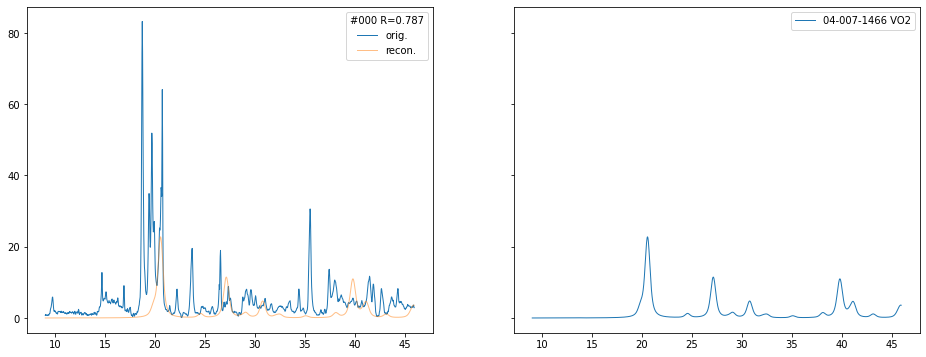

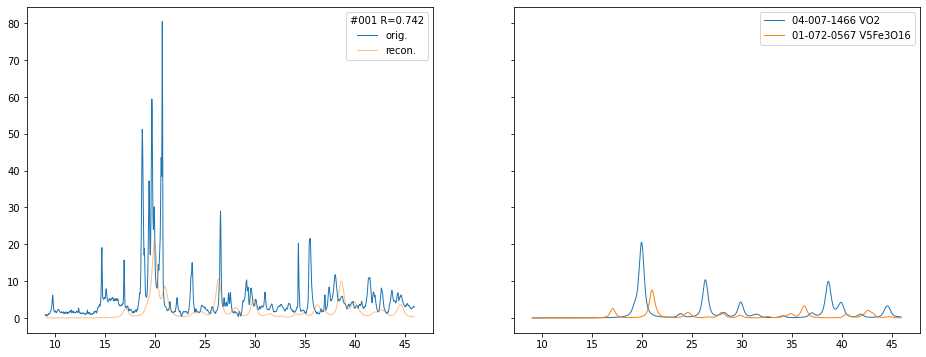

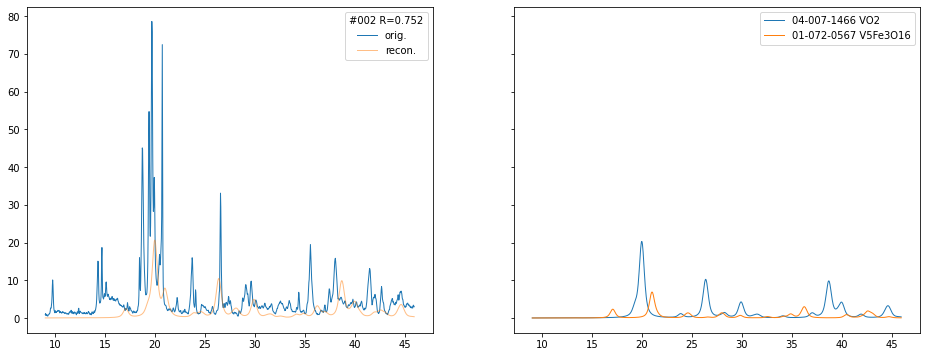

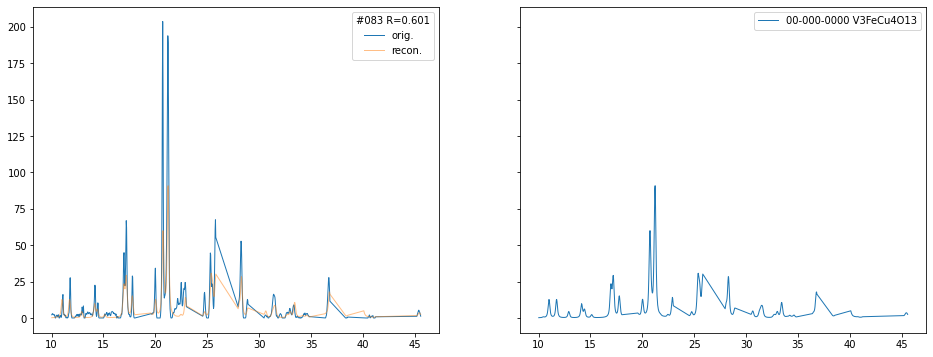

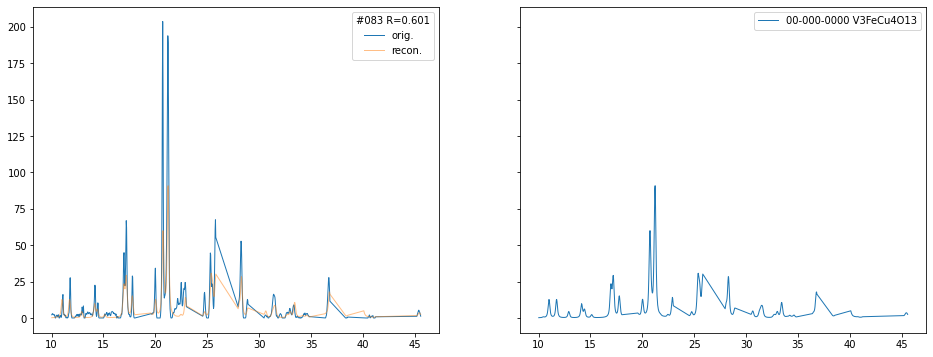

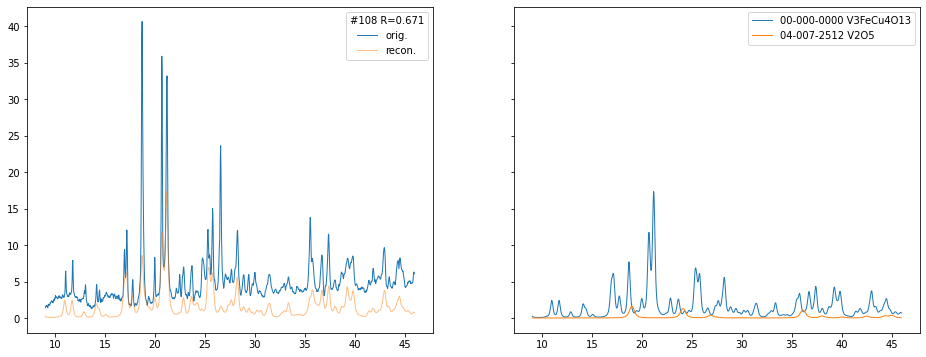

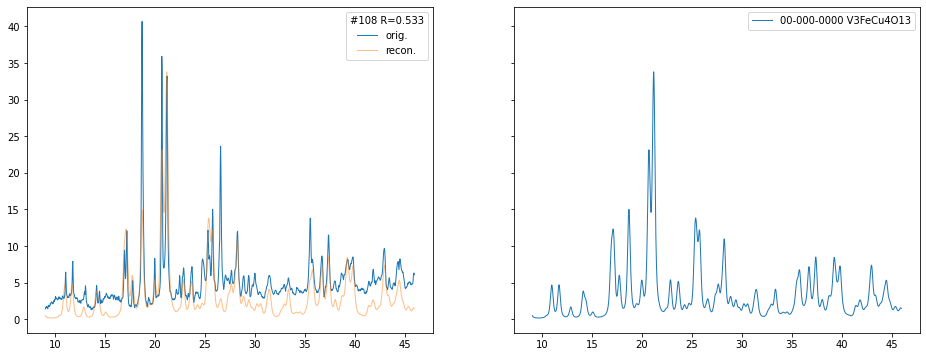

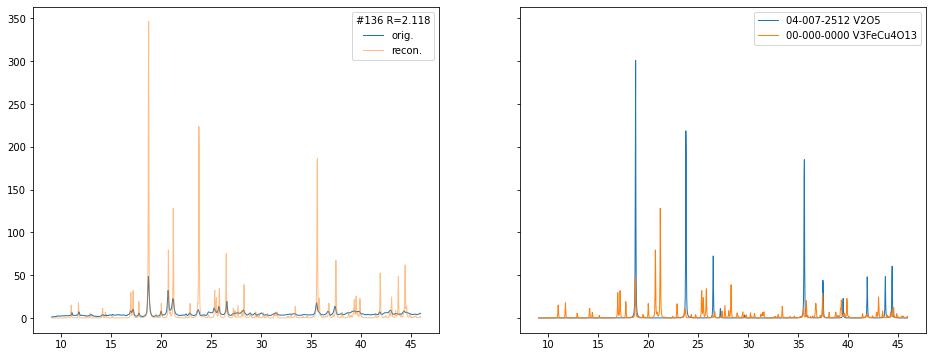

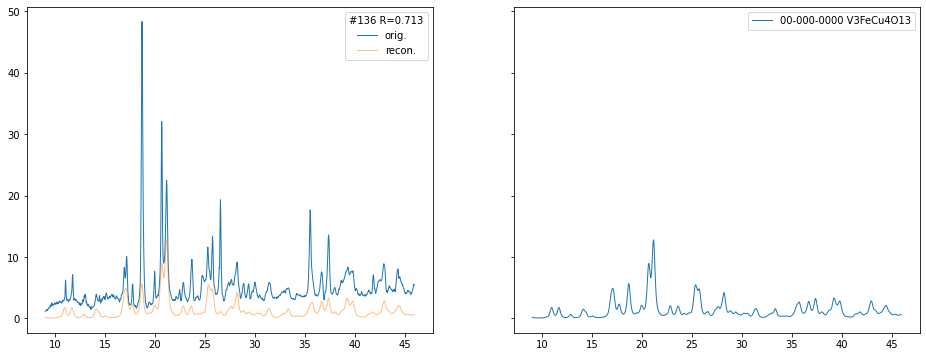

In [41]:
for i in range(instance_data.sample_num):
    solution_file = f'solution/samples{i}.json'
    if os.path.exists(solution_file):
        with open(solution_file) as f:
            sample = json.load(f, cls=MontyDecoder)
            
        sample.plot(perphase=True)    
        print(f'Solving sample {i} ......') 
        
        if (len(sample.solution)) <1:
            #continue
            print (len(sample.solution))
            continue
        new_sample = deepcopy(sample)
        new_sample.refine_all_fractions()
        new_sample.refine_one_by_one()
        if new_sample.loss(loss_weight) <= sample.loss(loss_weight):
            new_sample.print_solution()
            solution_file = f'solution/samples{i}.json'
            with open(solution_file, 'w') as f:
                json.dump(new_sample, f, cls=MontyEncoder)
        
        
        new_sample = new_sample.optimize(num_epoch=500, print_prog=True, loss_weight=loss_weight)
        new_sample.update_solution(0.03, 0.2999, new_sample.max_q_shift)
        
        if (len(new_sample.solution)) <1:
            #continue
            print (len(new_sample.solution))
            continue
        
        
        new_sample.plot(perphase=True)
        
        new_sample.refine_all_fractions()
        new_sample.refine_one_by_one()
        new_sample.update_solution(0.03, 0.2999, new_sample.max_q_shift)
        
        if new_sample.loss(loss_weight) <= sample.loss(loss_weight):
            new_sample.print_solution()
            solution_file = f'solution/samples{i}.json'
            with open(solution_file, 'w') as f:
                json.dump(new_sample, f, cls=MontyEncoder)
    else:
        continue
        
        
        #solution = [Phase.from_entry_and_instance_data(entries[-1], 1, instance_data,width=0.1)]
        
        
# #         print(sample.sample_id, sample.loss(loss_weight))
        
#         new_sample = deepcopy(sample)
        
#         #new_sample.refine_all_fractions()
#         #new_sample.refine_one_by_one()
        
#         new_sample = new_sample.optimize(num_epoch=500, print_prog=True, loss_weight=loss_weight)
#         new_sample.update_solution(0.03, 0.2999, new_sample.max_q_shift)
#         new_sample.refine_all_fractions()
#         new_sample.refine_one_by_one()
#         new_sample.update_solution(0.03, 0.2999, new_sample.max_q_shift)
#         #new_sample.refine_all_fractions()
# #         new_sample = new_sample.optimize(num_epoch=1000, print_prog=True, loss_weight=loss_weight)
# #         new_sample.update_solution(0.01, 0.2999, new_sample.max_q_shift)
# #         new_sample.refine_one_by_one()
# #         new_sample.refine_all_fractions()
# #         new_sample.update_solution(0.01, 0.2999, new_sample.max_q_shift)
# #        print(new_sample.loss(loss_weight))
#         if new_sample.loss(loss_weight) <= sample.loss(loss_weight):
#             #sample.print_solution()
#             new_sample.print_solution()
#             #samples[sample.sample_id] = new_sample
#             solution_file = f'solution/samples{i}.json'
#             with open(solution_file, 'w') as f:
#                 json.dump(new_sample, f, cls=MontyEncoder)
#             print(sample.sample_id, sample.loss(loss_weight))


In [ ]:
new_sample.print_solution()

In [ ]:
new_sample.plot(perphase=True)

In [ ]:
plt.plot(np.exp(instance_data.log_q),background)

In [ ]:
from pymatgen.ext.matproj import MPRester
with MPRester() as m:
    data = m.query(criteria={"pretty_formula":'SnO2',
                             "icsd_ids": { "$exists": True, "$ne": [] },
                             "nelements": {"$gt": 1,} ,
                             #oxide_type":{"$eq":'oxide'}
                            }, 
                   properties=[ "material_id","pretty_formula","icsd_ids",'final_structure','xrd.Ag'])

In [ ]:
for d in data:
    print (d['xrd.Ag']['pattern'][0])

In [ ]:
nrows=20
fig,axes = plt.subplots(20,4,sharex=True,figsize=(16,2*nrows))
axes = axes.flatten()
for e,ax in zip(entries,axes):
    ax.text(0.85,0.85, e.name,
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes)
    
    xs,ys = (e.data['xrd'])
    
    for x,y in zip(xs,ys):
        ax.plot([x,x],[0,y],'C0')
    ax.plot(np.exp(instance_data.log_q),instance_data.sample_xrd[k]/np.max(instance_data.sample_xrd[k])*np.max(ys),'C1')
ax.set_xlim(15,25)
    

In [ ]:
ax = plt.subplot()
e=entries[47]
xs,ys = (e.data['xrd'])
    
for x,y in zip(xs,ys):
    ax.plot([x+.5,x+.5],[0,y],'C0')
        
ax.plot()
ax.plot(np.exp(instance_data.log_q),instance_data.sample_xrd[k]/np.max(instance_data.sample_xrd[k])*np.max(ys),'C1')


In [ ]:
#!open ./initial_pruning/fig_14.pdf   


In [ ]:
for sample in samples:
    if True:
        # if min([count_act[_.entry_id] for _ in sample.entries])<5.0:
        # if sample.R > 0.4:
        print(sample.sample_id, sample.loss(loss_weight))
        # candidate_entries = []
        # for i in nn_list[sample.sample_id]:
        #     candidate_entries += samples[i].entries
        # candidate_entries = list(set(candidate_entries))
        # solution = []
        # for e in candidate_entries:
        #     phase = Phase.from_entry_and_instance_data(e, 1 / len(candidate_entries), instance_data)
        #     solution.append(phase)

        new_sample = deepcopy(sample)
        # new_sample.solution = solution
        # au = new_sample.to_auto
        new_sample = new_sample.optimize(num_epoch=500, print_prog=True, loss_weight=loss_weight)
        new_sample.update_solution(0.03, 0.2999, new_sample.max_q_shift)

        new_sample = new_sample.optimize(num_epoch=3000, print_prog=True, loss_weight=loss_weight)
        new_sample.update_solution(0.01, 0.2999, new_sample.max_q_shift)

        new_sample.refine_one_by_one()
        new_sample.refine_all_fractions()

        new_sample.update_solution(0.01, 0.2999, new_sample.max_q_shift)
        print(new_sample.loss(loss_weight))
        if new_sample.loss(loss_weight) <= sample.loss(loss_weight):
            sample.print_solution()
            new_sample.print_solution()
            samples[sample.sample_id] = new_sample
            solution_file = f'solution/samples{sample.sample_id}.json'
            with open(solution_file, 'w') as f:
                json.dump(sample, f, cls=MontyEncoder)